In [39]:
import h5py
import numpy as np
import pickle
import scipy
from scipy.stats import norm
from collections import defaultdict

import matplotlib
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
#textsize = 'xx-large'
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': 18,
         'axes.titlesize': 22,
         'xtick.labelsize': 16,
         'ytick.labelsize': 16,
         'figure.facecolor': 'w'}
pylab.rcParams.update(params)
from matplotlib import pyplot as plt
from matplotlib import gridspec

import dynesty
import seaborn as sns
from dynesty import utils as dyfunc
from getdist import plots, MCSamples

%matplotlib inline  
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(1, '../code')
import plotter
import utils
from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#plot_dir = '../paper/images'
plot_dir = '../plots/plots_2023-06-21'

# Style, labels, and general

In [116]:
statistics = ['wp', 'xi', 'xi2', 'upf', 'mcf']
stat_strs_single = np.loadtxt('../tables/statistic_sets_single.txt', dtype=str)
stat_strs_addin = np.loadtxt('../tables/statistic_sets_addin.txt', dtype=str)
stat_strs_addin_full = np.concatenate((['wp'], stat_strs_addin))
stat_strs_scale = np.concatenate((stat_strs_single, 
                                 ['xi_xi2', 'wp_xi_xi2', 'wp_xi_xi2_mcf', 'wp_xi_xi2_upf_mcf']))

params_keydeliverable = ['Omega_m', 'sigma_8', 'f', 'fsigma8']
params_keycosmo = ['Omega_m', 'sigma_8', 'f']
params_keyhodab = ['M_sat', 'v_bs', 'f_env']
params_keymix = ['Omega_m', 'sigma_8', 'f', 'M_sat', 'v_bs', 'f_env']

id_pairs = np.loadtxt('../tables/id_pairs_recovery_test_70.txt', delimiter=',', dtype=np.int)

In [117]:
labels_single = [
                 make_label('wp'),
                 make_label('xi'),
                 make_label('xi2'),
                 make_label('upf'),
                 make_label('mcf')
                ]
labels_addin = [
                 make_label('wp'),
                 '+'+make_label('xi'),
                 '+'+make_label('xi2'),
                 '+'+make_label('upf'),
                 '+'+make_label('mcf'),
                ]
labels_addin_full = [
                 make_label('wp'),
                 make_label(['wp', 'xi']),
                 make_label(['wp', 'xi', 'xi2']),
                 make_label(['wp', 'xi', 'xi2', 'upf']),
                 make_label(['wp', 'xi', 'xi2', 'upf', 'mcf'])
                ]
labels_scale = np.concatenate((labels_single, 
                               [make_label(['xi', 'xi2']),
                                make_label(['wp', 'xi', 'xi2']),
                                make_label(['wp', 'xi', 'xi2', 'mcf']),
                                make_label(['wp', 'xi', 'xi2', 'upf', 'mcf'])]))


In [119]:
colors_single = ['#73B9F3', '#2B66CE', '#31D8BF', '#FFB142', '#F97FF0']
colors_addin = ['#73B9F3', '#8973F5', '#952DAD', '#D81471', '#B70D0D']
colors_scale = np.concatenate((colors_single, 
                               ['navy', colors_addin[2], '#ff33b4', colors_addin[-1]]))
colors_cov = ['#7B767B', colors_addin[-1]]

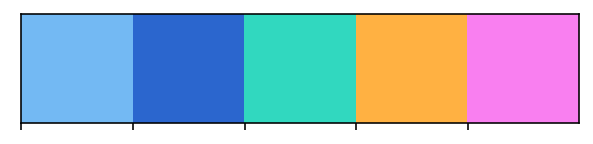

In [120]:
sns.palplot(sns.color_palette(colors_single))

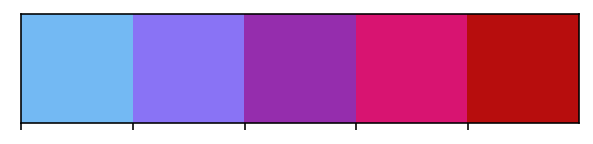

In [121]:
sns.palplot(sns.color_palette(colors_addin))

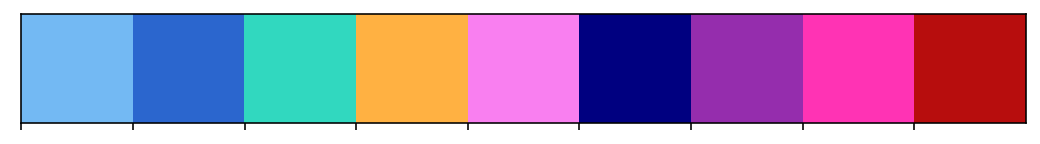

In [122]:
sns.palplot(sns.color_palette(colors_scale))

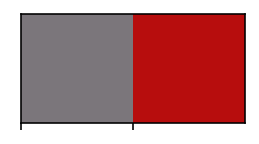

In [123]:
sns.palplot(sns.color_palette(colors_cov))

# Loading in data

Load in 70-model recovery test result dictionaries:

In [10]:
results_dict_dir = '../data_products/results_dicts'

In [11]:
chaintag_prior = 'prior'
prior_dict = utils.construct_results_dict(chaintag_prior)

In [12]:
fn_results_dict_single = f'{results_dict_dir}/results_dict_single.npy'
results_dict_single = np.load(fn_results_dict_single, allow_pickle=True).item()

In [13]:
fn_results_dict_addin_full = f'{results_dict_dir}/results_dict_addin_full.npy'
results_dict_addin_full = np.load(fn_results_dict_addin_full, allow_pickle=True).item()

In [14]:
fn_results_dict_wpximaxscale6 = f'{results_dict_dir}/results_dict_wpximaxscale6.npy'
results_dict_wpximaxscale6 = np.load(fn_results_dict_wpximaxscale6, allow_pickle=True).item()
# fn_results_dict_wpmaxscale6 = f'{results_dict_dir}/results_dict_wpmaxscale6.npy'
# results_dict_wpmaxscale6 = np.load(fn_results_dict_wpmaxscale6, allow_pickle=True).item()

In [18]:
# fn_results_dict_minscales = f'{results_dict_dir}/results_dict_minscales_upfmatch.npy'
#fn_results_dict_minscales = f'{results_dict_dir}/results_dict_minscales_mini.npy'
fn_results_dict_minscales = f'{results_dict_dir}/results_dict_minscales.npy'
results_dict_minscales = np.load(fn_results_dict_minscales, allow_pickle=True).item()

In [21]:
#fn_results_dict_maxscales = f'{results_dict_dir}/results_dict_maxscales_upfmatch.npy'
fn_results_dict_maxscales = f'{results_dict_dir}/results_dict_maxscales.npy'
results_dict_maxscales = np.load(fn_results_dict_maxscales, allow_pickle=True).item()

# Figures (Main paper body)

### Emulator 3-panel accuracy plot

In [10]:
train_tags = [f'_{utils.get_fiducial_emu_name(s)}_{utils.get_fiducial_emu_scaling(s)}_errstdev_fmaxmocks' for s in statistics]
plotter.plot_accuracy_figure(statistics, train_tags)
plt.savefig(f'{plot_dir}/emu_accuracy.pdf', bbox_inches='tight')

### Figure 2. Covariance matrices: a) sample variance; b) emulator performance

In [23]:
errtag = '_hod3_test0'
cov_dir = '../covariances'    
stat_str = '_'.join(statistics)

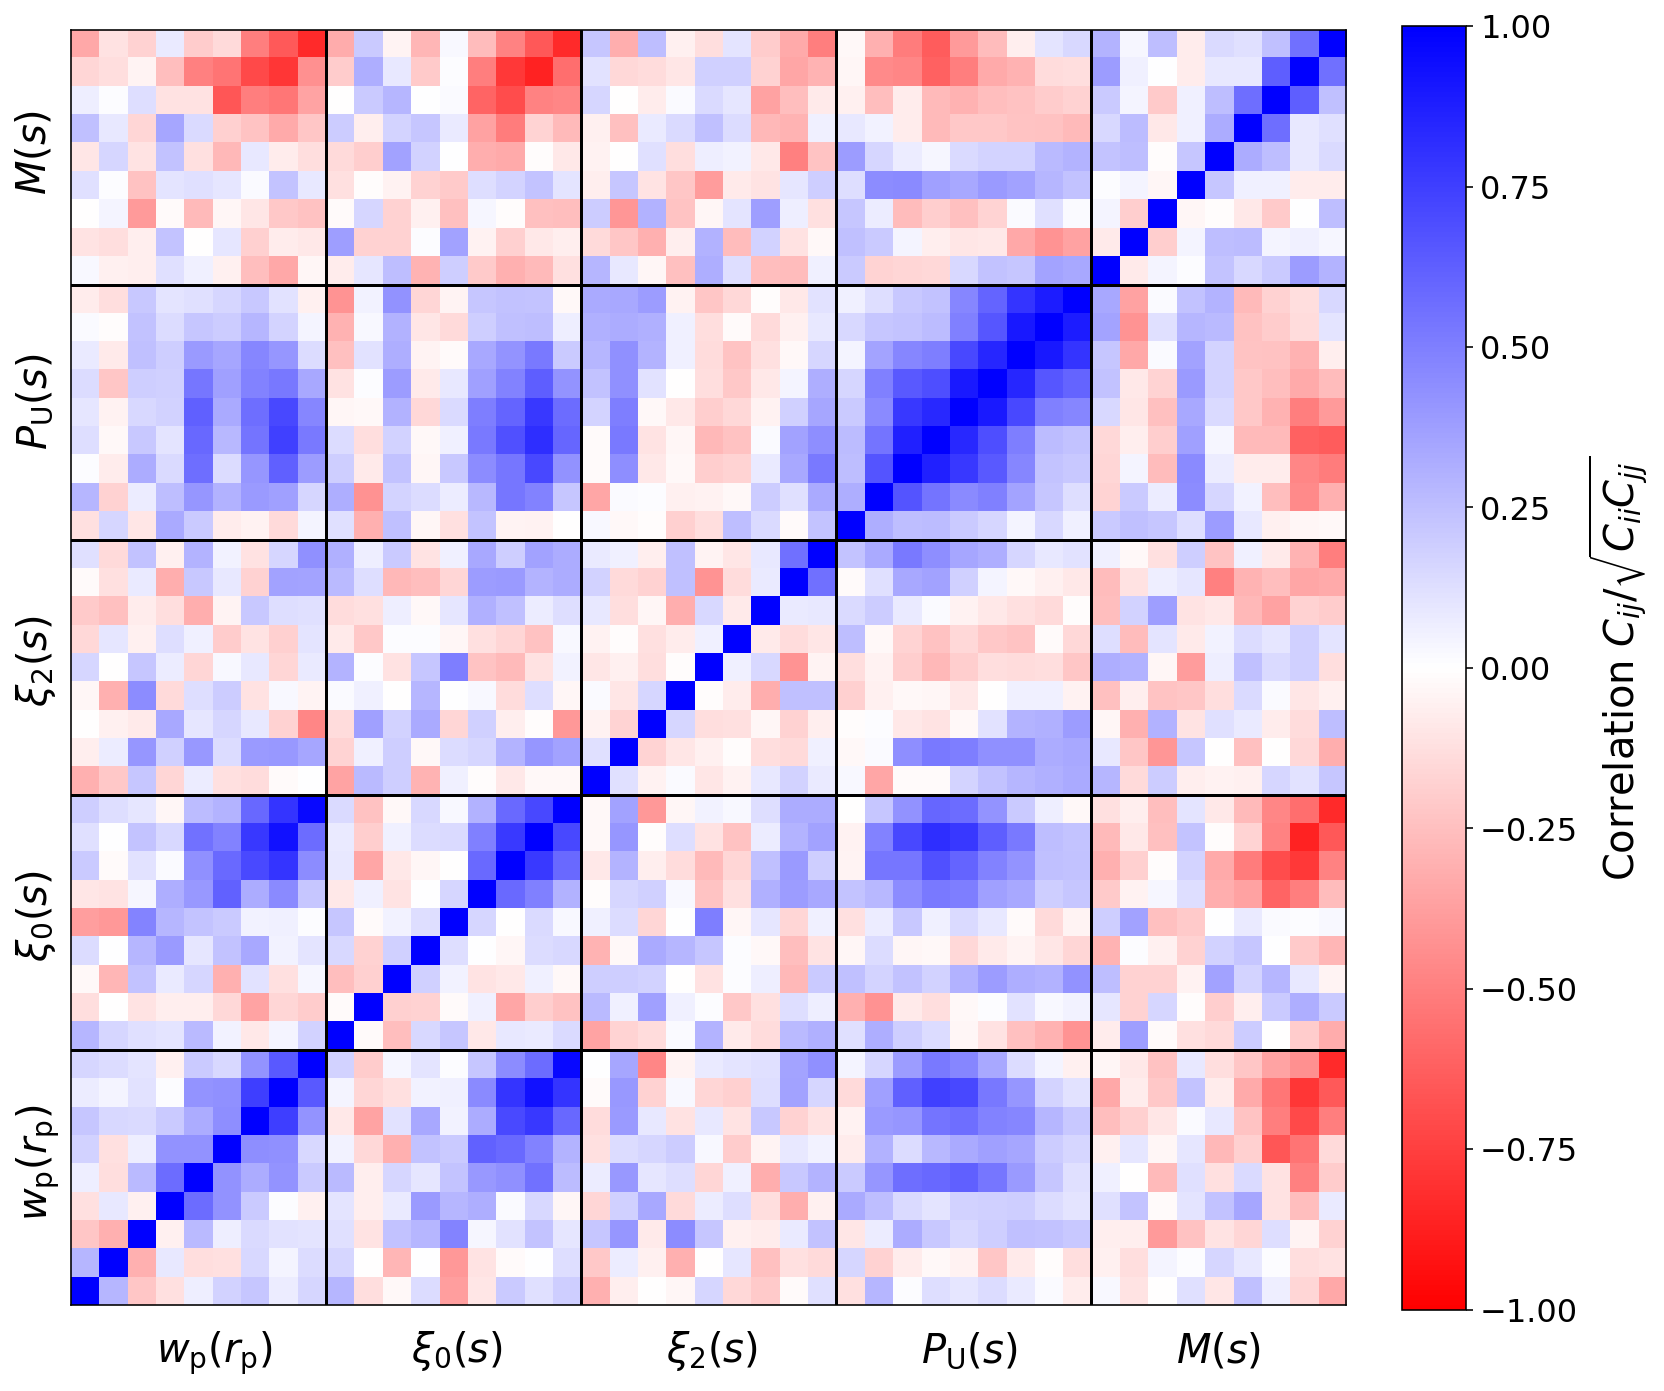

In [24]:
cov_tag_aem = 'aemulus_fmaxmocks_test'
cov_fn_aem = f"{cov_dir}/cov_{cov_tag_aem}_{stat_str}{errtag}.dat"

cov_aem = np.loadtxt(cov_fn_aem)
corr_aem = utils.reduced_covariance(cov_aem)
plotter.plot_correlation_matrix(corr_aem, statistics)
plt.savefig(f'{plot_dir}/corr_aemulus.pdf', bbox_inches='tight')

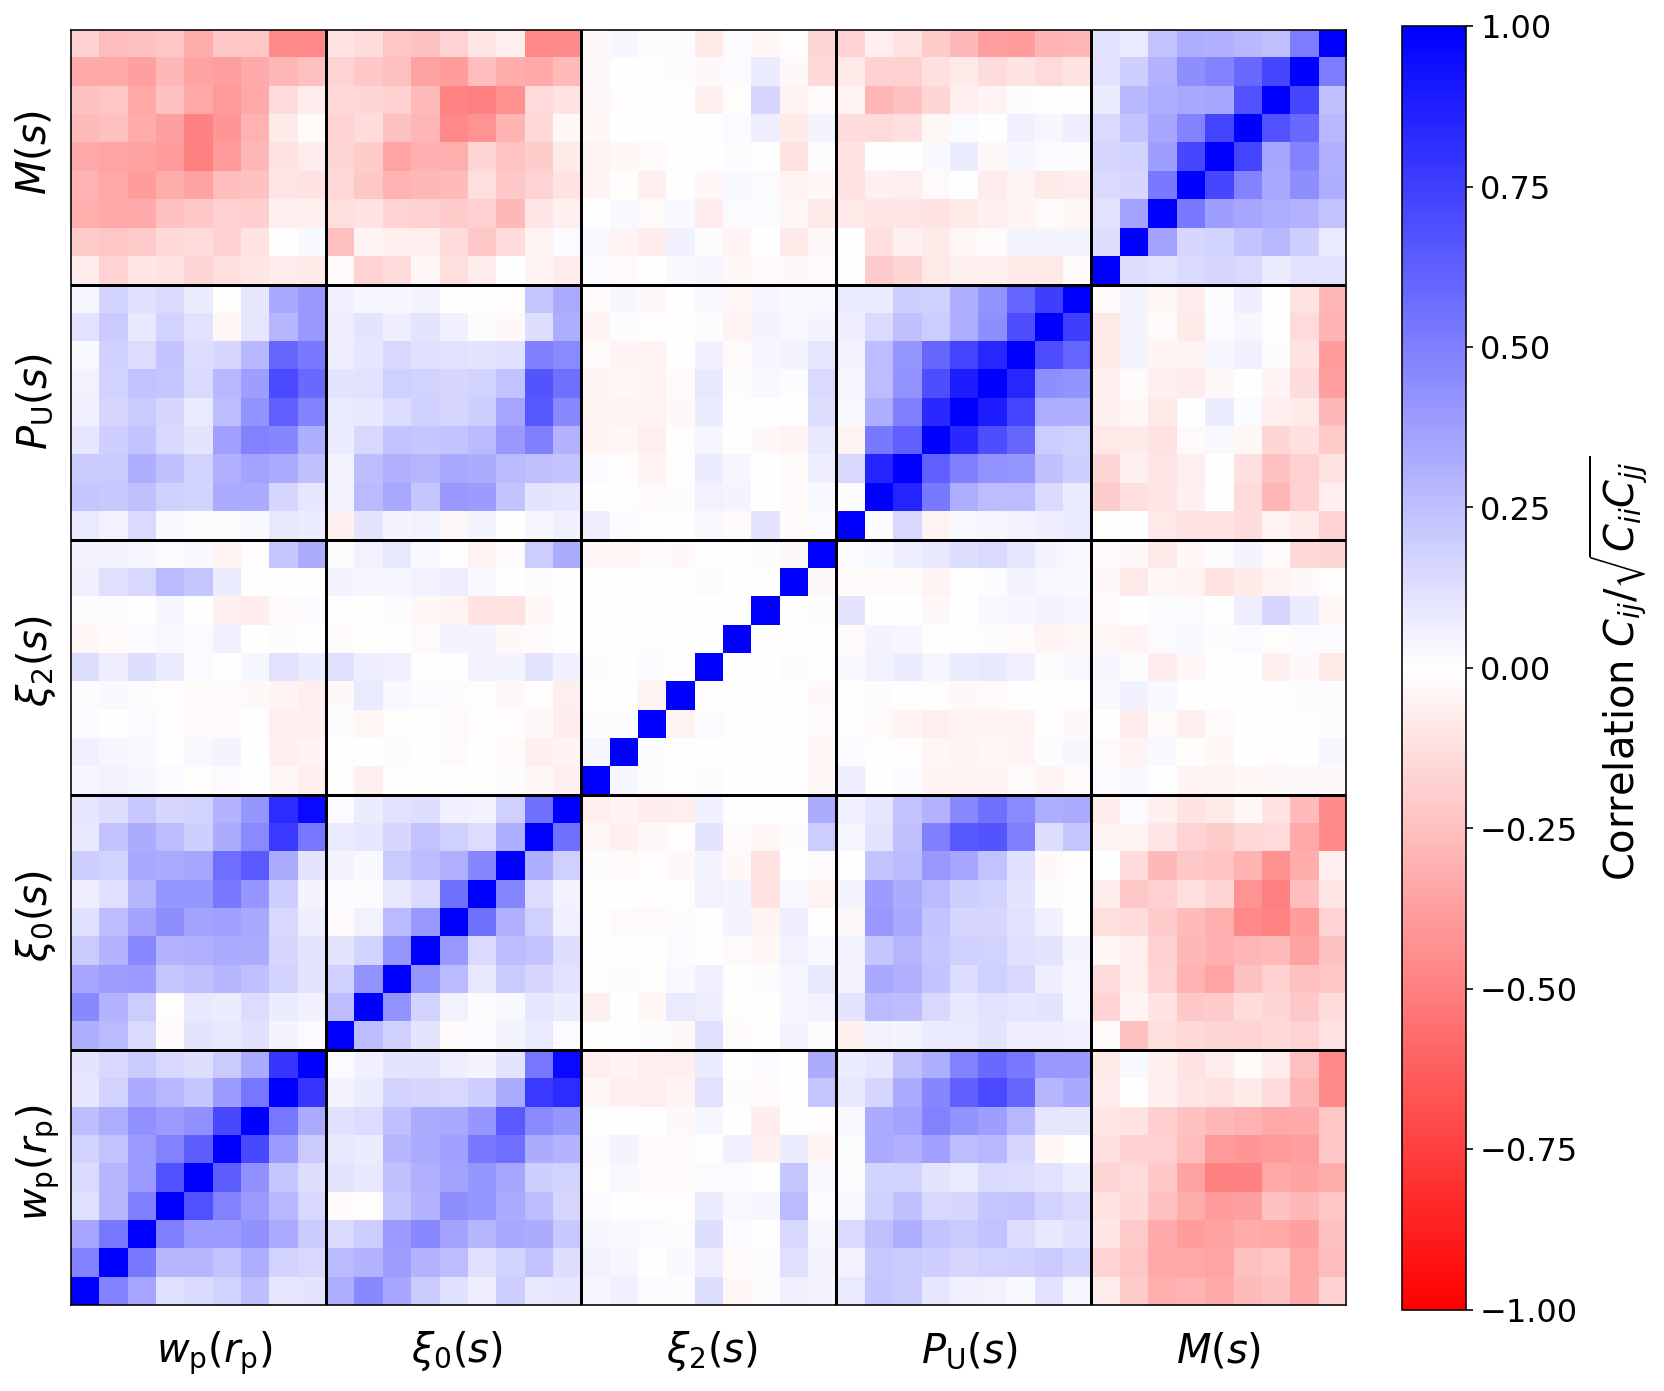

In [25]:
cov_tag_emuperf = 'emuperf_aemulus_fmaxmocks_test'
cov_fn_emuperf = f"{cov_dir}/cov_{cov_tag_emuperf}_{stat_str}{errtag}.dat"

cov_emuperf = np.loadtxt(cov_fn_emuperf)
corr_emuperf = utils.reduced_covariance(cov_emuperf)
plotter.plot_correlation_matrix(corr_emuperf, statistics)
plt.savefig(f'{plot_dir}/corr_emuperf.pdf', bbox_inches='tight')

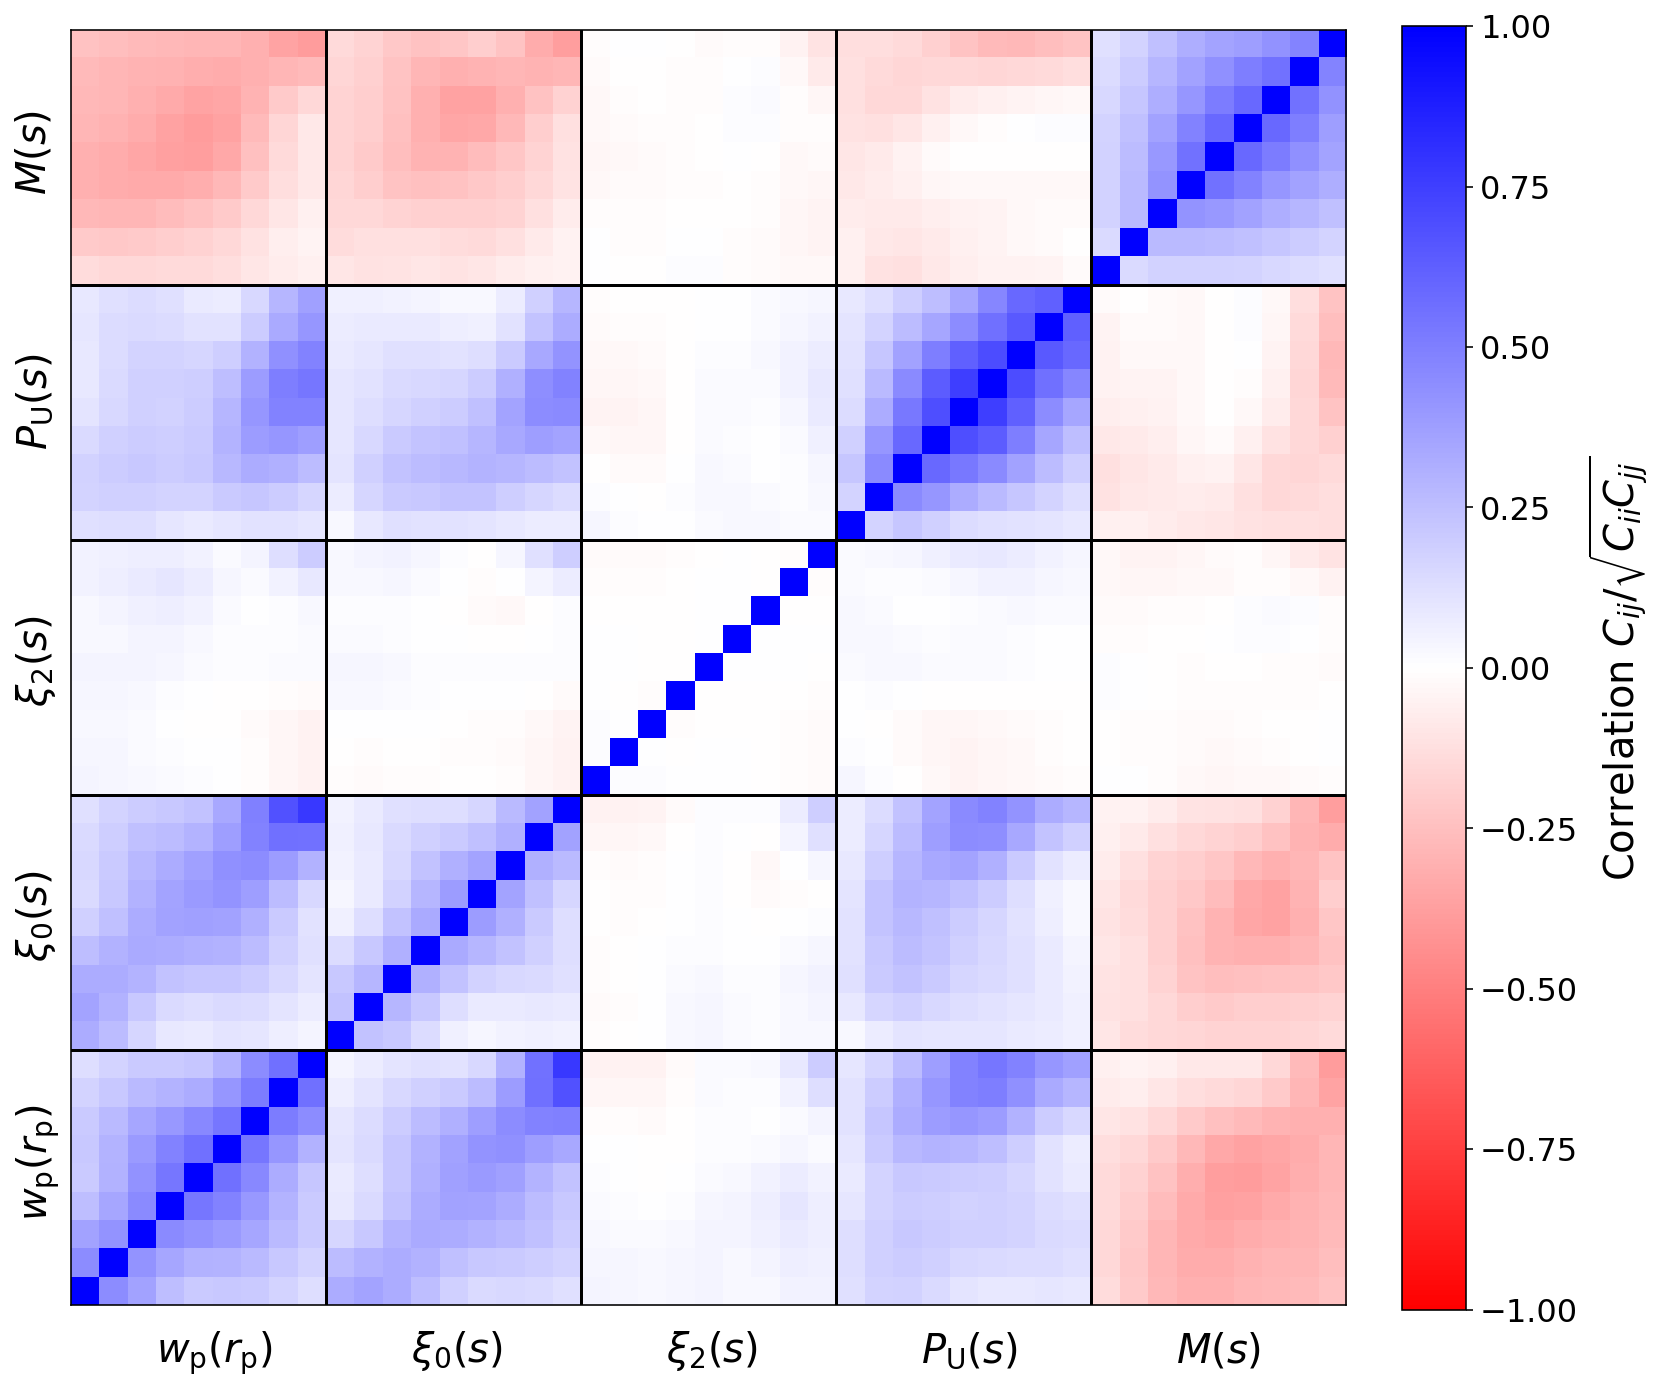

In [26]:
cov_tag_emuperf_smooth = 'smoothgauss_emuperf_aemulus_fmaxmocks_test'
cov_fn_emuperf_smooth = f"{cov_dir}/cov_{cov_tag_emuperf_smooth}_{stat_str}{errtag}.dat"

cov_emuperf_smooth = np.loadtxt(cov_fn_emuperf_smooth)
corr_emuperf_smooth = utils.reduced_covariance(cov_emuperf_smooth)
plotter.plot_correlation_matrix(corr_emuperf_smooth, statistics)
plt.savefig(f'{plot_dir}/corr_smoothgauss_emuperf.pdf', bbox_inches='tight')

### Covariance amplitude comparison

/home/users/ksf293/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in sqrt


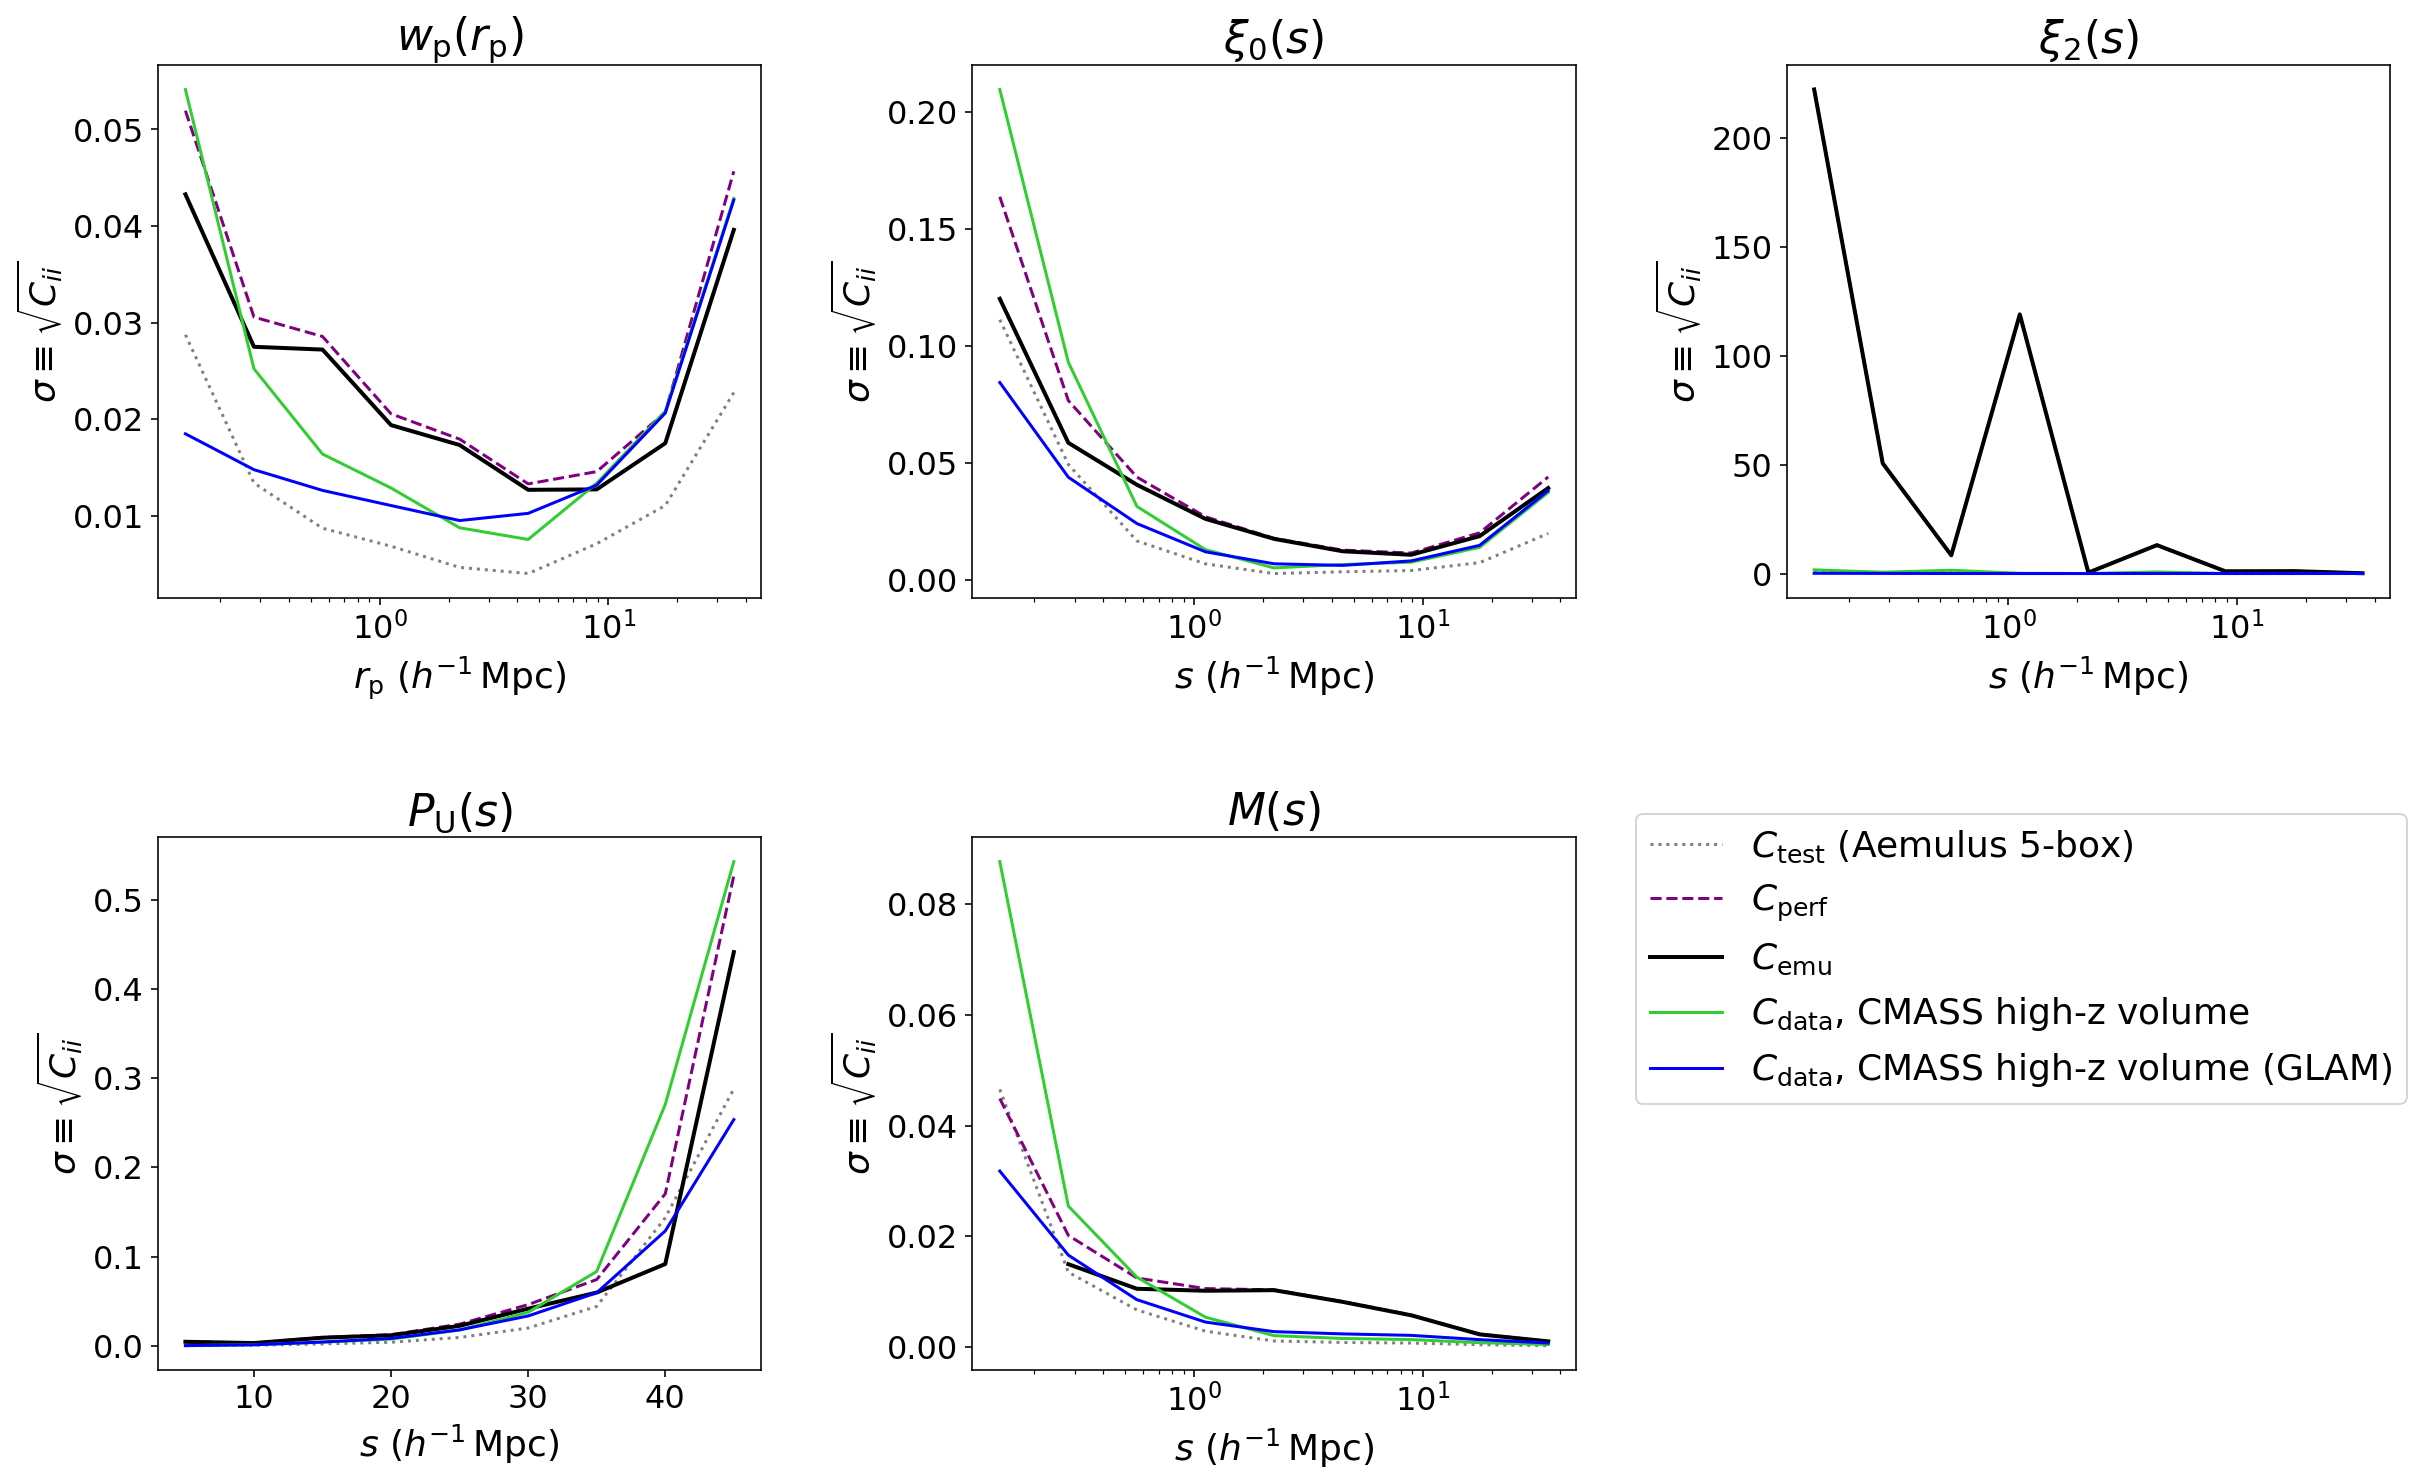

In [78]:
%matplotlib inline
statistics = ['wp', 'xi', 'xi2', 'upf', 'mcf']
mock_tag = '_aemulus_fmaxmocks_test'
cov_tag_extra = ''

fig = plt.figure(figsize=(20, 12))
outer = gridspec.GridSpec(2, 3, wspace=0.35, hspace=0.45)

vol_cmass_highz = 1.63
vol_aem = 1.05**3

for i, statistic in enumerate(statistics):
        
    stat_str = statistic
    cov_tag = mock_tag
    cov_aemulus_fn = f"{cov_dir}/cov{cov_tag}_{stat_str}{errtag}.dat"
    cov_aemulus = np.loadtxt(cov_aemulus_fn)
    cov_aemulus_5box = cov_aemulus*(1/5)
    
    cov_tag = 'emuperf'+mock_tag+cov_tag_extra
    cov_emuperf_fn = f"{cov_dir}/cov_{cov_tag}_{stat_str}{errtag}.dat"
    cov_emuperf = np.loadtxt(cov_emuperf_fn)

    cov_tag = 'smoothgauss_emuperf'+mock_tag+cov_tag_extra
    cov_emuperf_smooth_fn = f"{cov_dir}/cov_{cov_tag}_{stat_str}{errtag}.dat"
    cov_emuperf_smooth = np.loadtxt(cov_emuperf_smooth_fn)
    
    #cov_combined_fn = f"{cov_dir}/cov_combined{mock_tag}{cov_tag_extra}_uchuuglam_smooth_{stat_str}.dat"
    #cov_combined = np.loadtxt(cov_combined_fn)
    
    #plt.figure()
    ax = plt.Subplot(fig, outer[i])

    ax.plot(r_dict[statistic], np.sqrt(np.diag(cov_aemulus_5box)), color='grey', ls=':', 
            label=r'$C_\mathrm{test}$ (Aemulus 5-box)')
    ax.plot(r_dict[statistic], np.sqrt(np.diag(cov_emuperf_smooth)), color='purple', label='$C_\mathrm{perf}$', ls='--')
    
    cov_emu = cov_emuperf_smooth - cov_aemulus_5box
    ax.plot(r_dict[statistic], np.sqrt(np.diag(cov_emu)), color='black', lw=2, label='$C_\mathrm{emu}$')
    
    cov_cmass = vol_aem/vol_cmass_highz * cov_aemulus
    ax.plot(r_dict[statistic], np.sqrt(np.diag(cov_cmass)), color='limegreen', label=r'$C_\mathrm{data}$, CMASS high-z volume')

    L_glam = 1. #Gpc/h
    vol_glam = L_glam**3
    cov_glam_fn = f'{cov_dir}/cov_glam_{stat_str}.dat'
    cov_glam = np.loadtxt(cov_glam_fn)
    cov_cmass_glam = vol_glam/vol_cmass_highz * cov_glam
    ax.plot(r_dict[statistic], np.sqrt(np.diag(cov_cmass_glam)), color='blue', 
            label=r'$C_\mathrm{data}$, CMASS high-z volume (GLAM)')
    
    ax.set_title(stat_labels[statistic])
    ax.set_xlabel(r_labels[statistic])
    ax.set_ylabel(r'$\sigma \equiv \sqrt{C_{ii}}$')

    ax.set_xscale(scale_dict[statistic][0])

    fig.add_subplot(ax)
    
handles_top, labels_top = ax.get_legend_handles_labels()
legend_top = plt.legend(handles=handles_top, fontsize=18, loc=(1.1, 0.5))

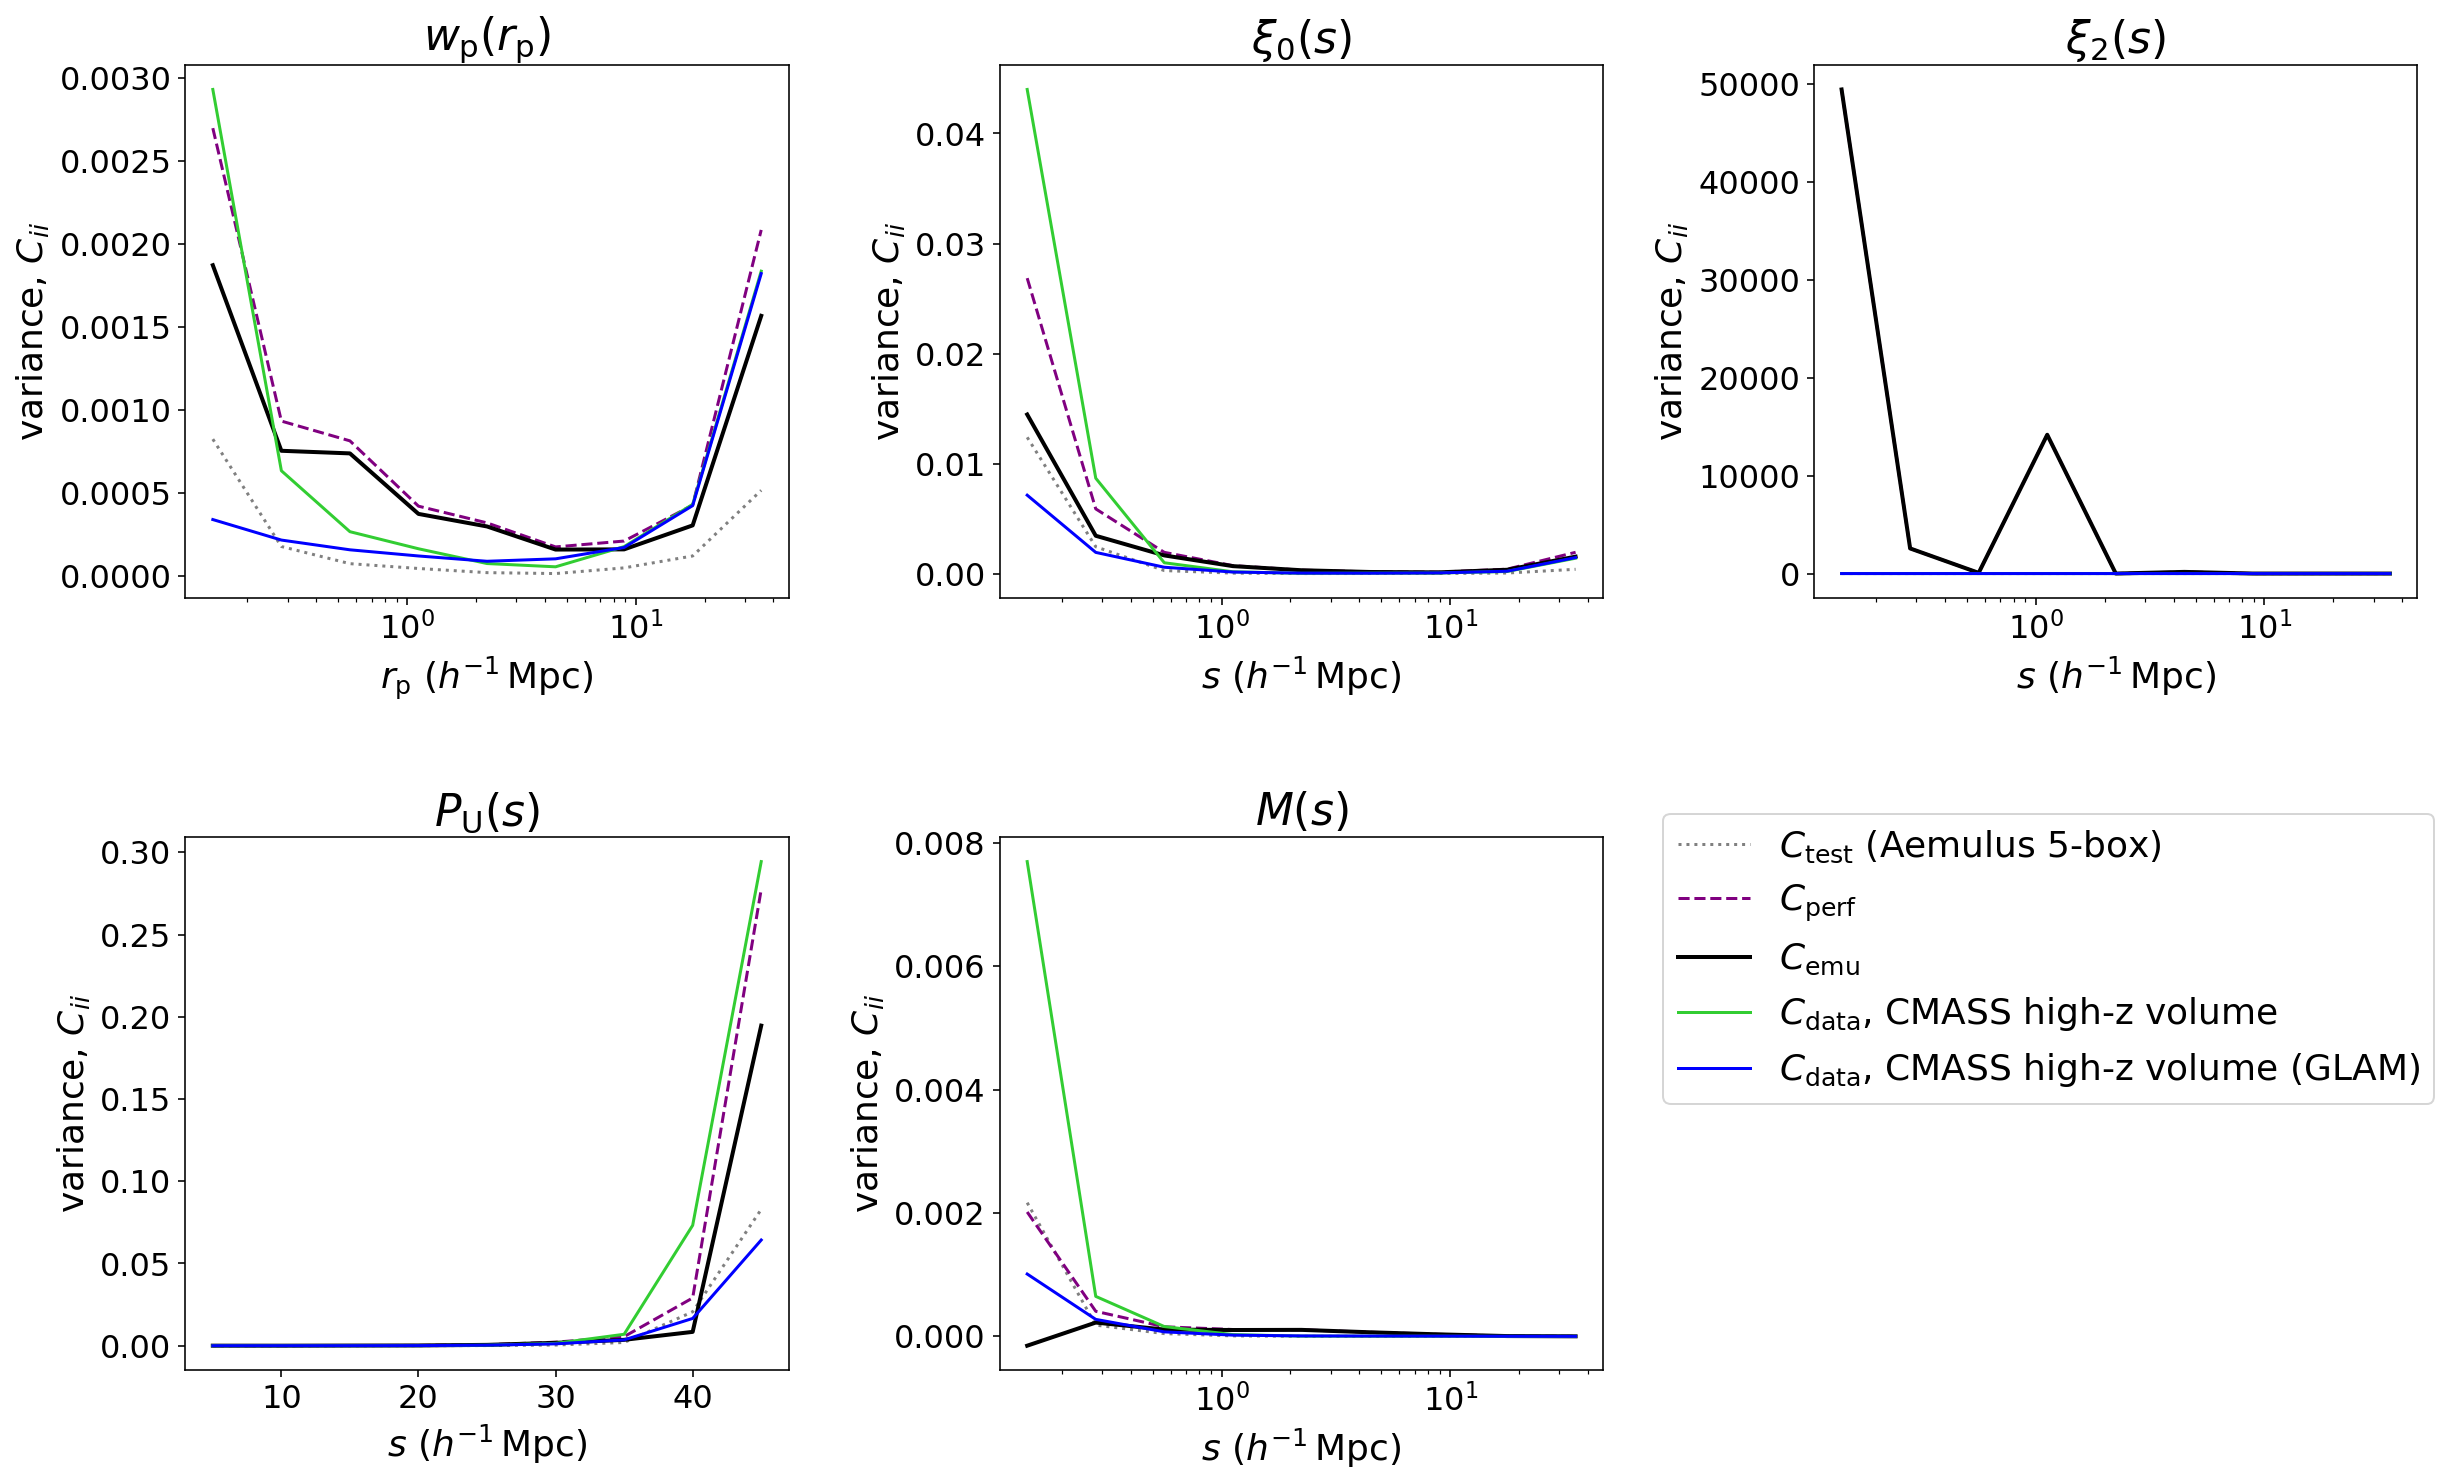

In [79]:
%matplotlib inline
statistics = ['wp', 'xi', 'xi2', 'upf', 'mcf']
mock_tag = '_aemulus_fmaxmocks_test'
cov_tag_extra = ''

fig = plt.figure(figsize=(20, 12))
outer = gridspec.GridSpec(2, 3, wspace=0.35, hspace=0.45)

vol_cmass_highz = 1.63
vol_aem = 1.05**3

for i, statistic in enumerate(statistics):
        
    stat_str = statistic
    cov_tag = mock_tag
    cov_aemulus_fn = f"{cov_dir}/cov{cov_tag}_{stat_str}{errtag}.dat"
    cov_aemulus = np.loadtxt(cov_aemulus_fn)
    cov_aemulus_5box = cov_aemulus*(1/5)
    
    cov_tag = 'emuperf'+mock_tag+cov_tag_extra
    cov_emuperf_fn = f"{cov_dir}/cov_{cov_tag}_{stat_str}{errtag}.dat"
    cov_emuperf = np.loadtxt(cov_emuperf_fn)

    cov_tag = 'smoothgauss_emuperf'+mock_tag+cov_tag_extra
    cov_emuperf_smooth_fn = f"{cov_dir}/cov_{cov_tag}_{stat_str}{errtag}.dat"
    cov_emuperf_smooth = np.loadtxt(cov_emuperf_smooth_fn)
    
    #cov_combined_fn = f"{cov_dir}/cov_combined{mock_tag}{cov_tag_extra}_uchuuglam_smooth_{stat_str}.dat"
    #cov_combined = np.loadtxt(cov_combined_fn)
    
    #plt.figure()
    ax = plt.Subplot(fig, outer[i])

    ax.plot(r_dict[statistic], np.diag(cov_aemulus_5box), color='grey', ls=':', 
            label=r'$C_\mathrm{test}$ (Aemulus 5-box)')
    ax.plot(r_dict[statistic], np.diag(cov_emuperf_smooth), color='purple', label='$C_\mathrm{perf}$', ls='--')
    
    cov_emu = cov_emuperf_smooth - cov_aemulus_5box
    ax.plot(r_dict[statistic], np.diag(cov_emu), color='black', lw=2, label='$C_\mathrm{emu}$')
    
    cov_cmass = vol_aem/vol_cmass_highz * cov_aemulus
    ax.plot(r_dict[statistic], np.diag(cov_cmass), color='limegreen', label=r'$C_\mathrm{data}$, CMASS high-z volume')

    L_glam = 1. #Gpc/h
    vol_glam = L_glam**3
    cov_glam_fn = f'{cov_dir}/cov_glam_{stat_str}.dat'
    cov_glam = np.loadtxt(cov_glam_fn)
    cov_cmass_glam = vol_glam/vol_cmass_highz * cov_glam
    ax.plot(r_dict[statistic], np.diag(cov_cmass_glam), color='blue', 
            label=r'$C_\mathrm{data}$, CMASS high-z volume (GLAM)')
    
    ax.set_title(stat_labels[statistic])
    ax.set_xlabel(r_labels[statistic])
    ax.set_ylabel(r'variance, $C_{ii}$')

    ax.set_xscale(scale_dict[statistic][0])

    fig.add_subplot(ax)
    
handles_top, labels_top = ax.get_legend_handles_labels()
legend_top = plt.legend(handles=handles_top, fontsize=18, loc=(1.1, 0.5))

### Contour plots, single observables

In [101]:
cosmo, hod = 1, 19

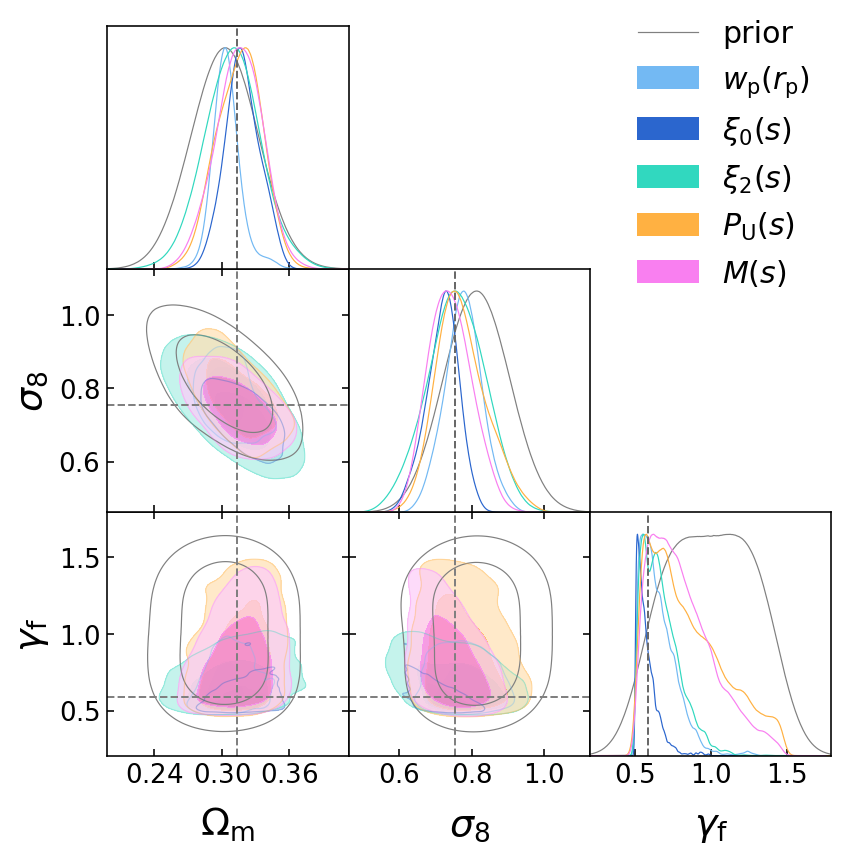

In [172]:
chaintags = [f'wp_aemulus_fmaxmocks_test_c{cosmo}h{hod}_minscale0',
             f'xi_aemulus_fmaxmocks_test_c{cosmo}h{hod}_minscale0',
             f'xi2_aemulus_fmaxmocks_test_c{cosmo}h{hod}_minscale0',
             f'upf_aemulus_fmaxmocks_test_c{cosmo}h{hod}_minscale0',
             f'mcf_aemulus_fmaxmocks_test_c{cosmo}h{hod}_minscale0',
            ]
g = plotter.plot_contours(chaintags, legend_labels=labels_single,
                          colors=colors_single, 
                          #legend_loc=(0.74,0.69), # no prior
                          legend_loc=(0.74,0.65), # with prior
                          legend_fontsize=18,
                          params_toplot=params_keycosmo, alpha=0.7, 
                          chaintag_prior='prior')
#plt.savefig(f'{plot_dir}/contour_single_cosmo.pdf', bbox_inches='tight')

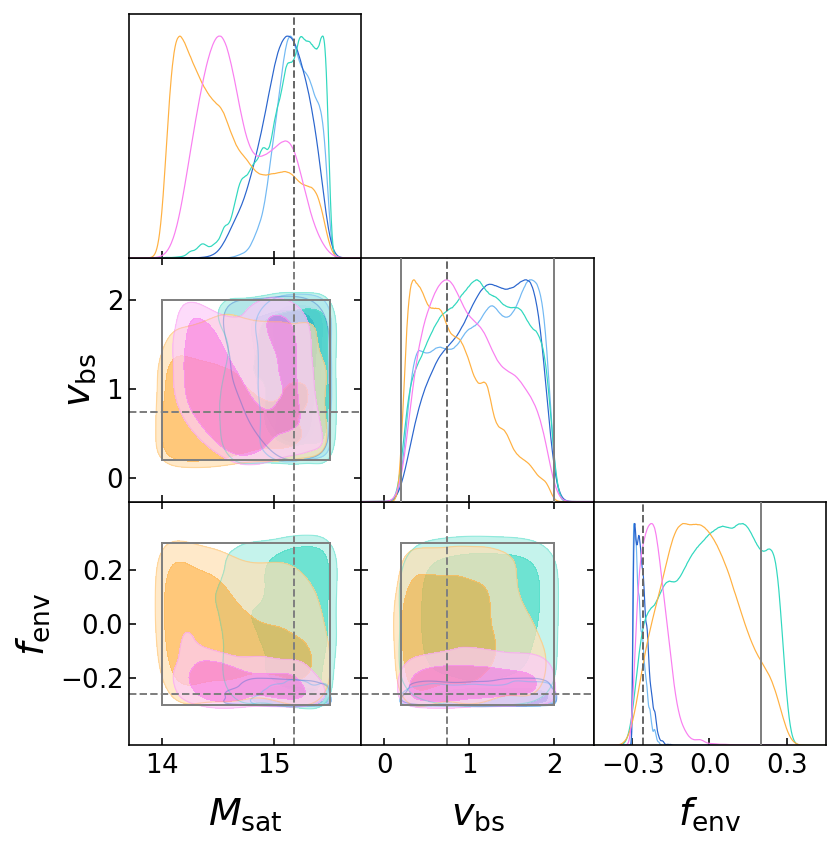

In [177]:
chaintags = [
             f'wp_aemulus_fmaxmocks_test_c{cosmo}h{hod}_minscale0',
             f'xi_aemulus_fmaxmocks_test_c{cosmo}h{hod}_minscale0',
             f'xi2_aemulus_fmaxmocks_test_c{cosmo}h{hod}_minscale0',
             f'upf_aemulus_fmaxmocks_test_c{cosmo}h{hod}_minscale0',
             f'mcf_aemulus_fmaxmocks_test_c{cosmo}h{hod}_minscale0',
            ]
g = plotter.plot_contours(chaintags, legend_labels=[],
                          colors=colors_single,
                          params_toplot=params_keyhodab, alpha=0.7,
                          plot_hard_prior=True
                          #chaintag_prior='prior'
                         )
plt.savefig(f'{plot_dir}/contour_single_hodab.pdf', bbox_inches='tight',
           chaintag_prior='prior')

### Contour plots, adding in observables

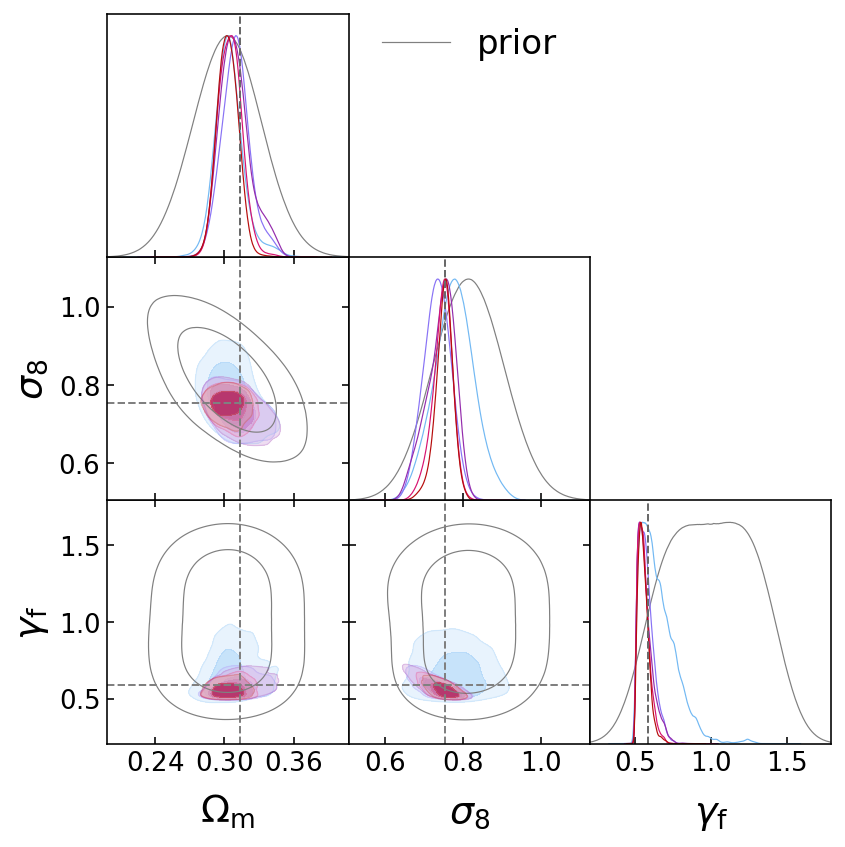

In [175]:
#cosmo, hod = 0, 1
#cosmo, hod = 1, 15
cosmo, hod = 1, 19
chaintags = [
             f'wp_aemulus_fmaxmocks_test_c{cosmo}h{hod}_minscale0',
             f'wp_xi_aemulus_fmaxmocks_test_c{cosmo}h{hod}_minscale0',
             f'wp_xi_xi2_aemulus_fmaxmocks_test_c{cosmo}h{hod}_minscale0',
             f'wp_xi_xi2_upf_aemulus_fmaxmocks_test_c{cosmo}h{hod}_minscale0',
             f'wp_xi_xi2_upf_mcf_aemulus_fmaxmocks_test_c{cosmo}h{hod}_minscale0',
            ]
g = plotter.plot_contours(chaintags, legend_labels=[],
                          colors=colors_addin,
                          params_toplot=params_keycosmo,
                          chaintag_prior='prior')
plt.savefig(f'{plot_dir}/contour_addin_cosmo.pdf', bbox_inches='tight')

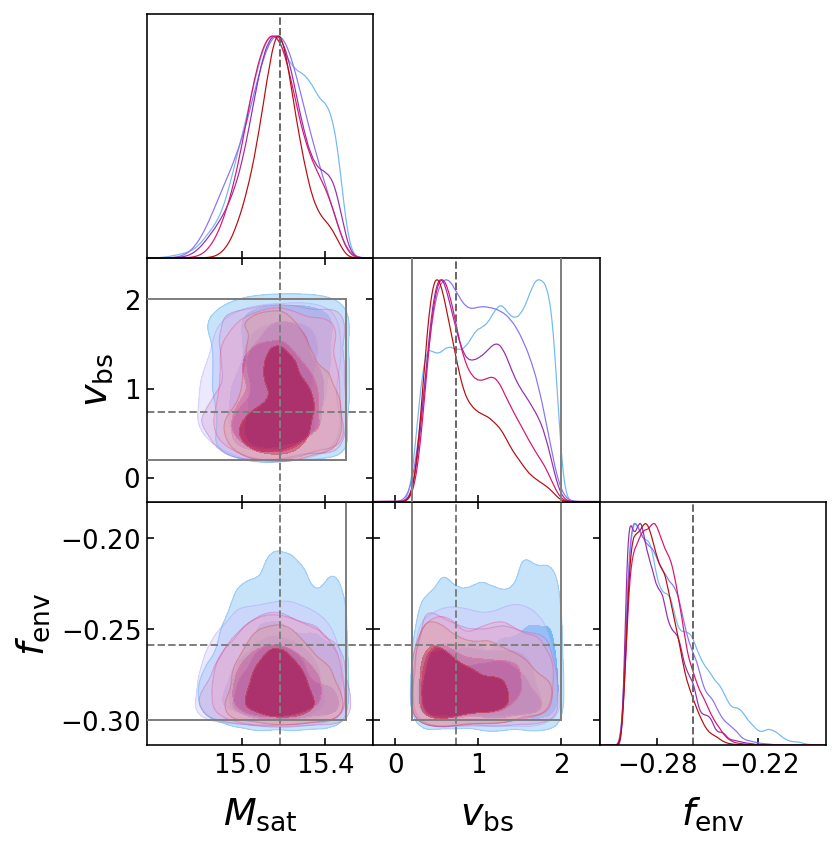

In [178]:
chaintags = [
             f'wp_aemulus_fmaxmocks_test_c{cosmo}h{hod}_minscale0',
             f'wp_xi_aemulus_fmaxmocks_test_c{cosmo}h{hod}_minscale0',
             f'wp_xi_xi2_aemulus_fmaxmocks_test_c{cosmo}h{hod}_minscale0',
             f'wp_xi_xi2_upf_aemulus_fmaxmocks_test_c{cosmo}h{hod}_minscale0',
             f'wp_xi_xi2_upf_mcf_aemulus_fmaxmocks_test_c{cosmo}h{hod}_minscale0',
            ]
g = plotter.plot_contours(chaintags, legend_labels=[],
                          colors=colors_addin,
                          params_toplot=params_keyhodab,
                          plot_hard_prior=True)
plt.savefig(f'{plot_dir}/contour_addin_hodab.pdf', bbox_inches='tight')

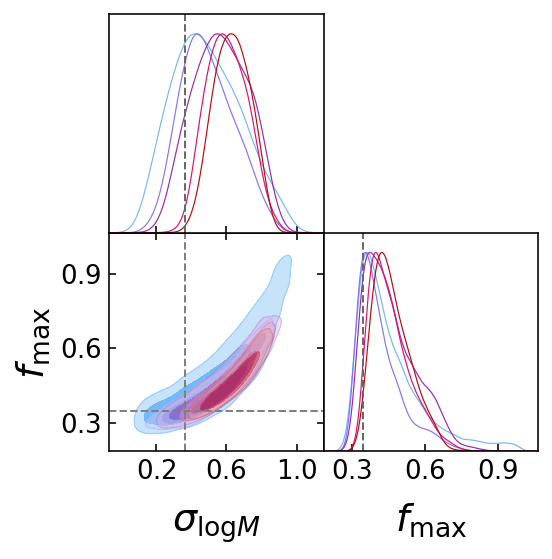

In [179]:
chaintags = [
             f'wp_aemulus_fmaxmocks_test_c{cosmo}h{hod}_minscale0',
             f'wp_xi_aemulus_fmaxmocks_test_c{cosmo}h{hod}_minscale0',
             f'wp_xi_xi2_aemulus_fmaxmocks_test_c{cosmo}h{hod}_minscale0',
             f'wp_xi_xi2_upf_aemulus_fmaxmocks_test_c{cosmo}h{hod}_minscale0',
             f'wp_xi_xi2_upf_mcf_aemulus_fmaxmocks_test_c{cosmo}h{hod}_minscale0',
            ]
g = plotter.plot_contours(chaintags, legend_labels=[],
                          colors=colors_addin,
                          params_toplot=['sigma_logM', 'f_max'])

### 70-model recovery test for single observables

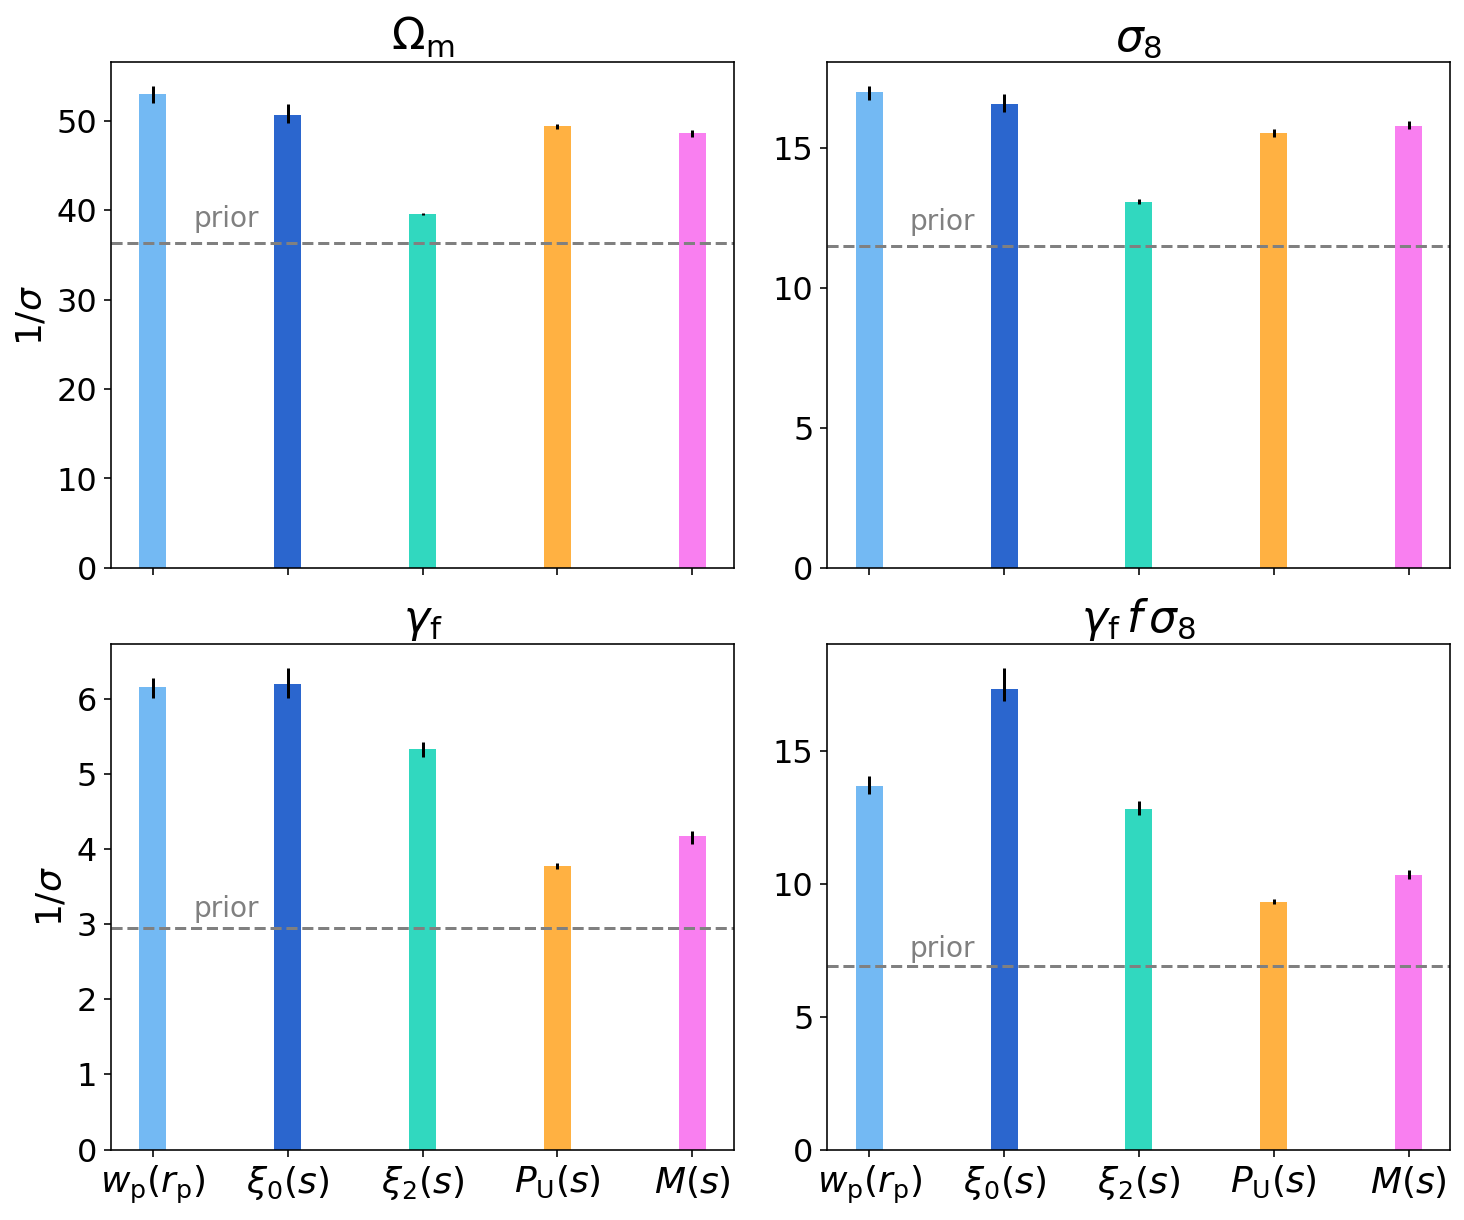

In [17]:
plotter.plot_uncertainty_figure(results_dict_single, prior_dict, params_keydeliverable, stat_strs_single, id_pairs, 
                                labels_single, colors_single)
plt.savefig(f'{plot_dir}/recovery_single.pdf', bbox_inches='tight')

### 70-model recovery test for adding in observables

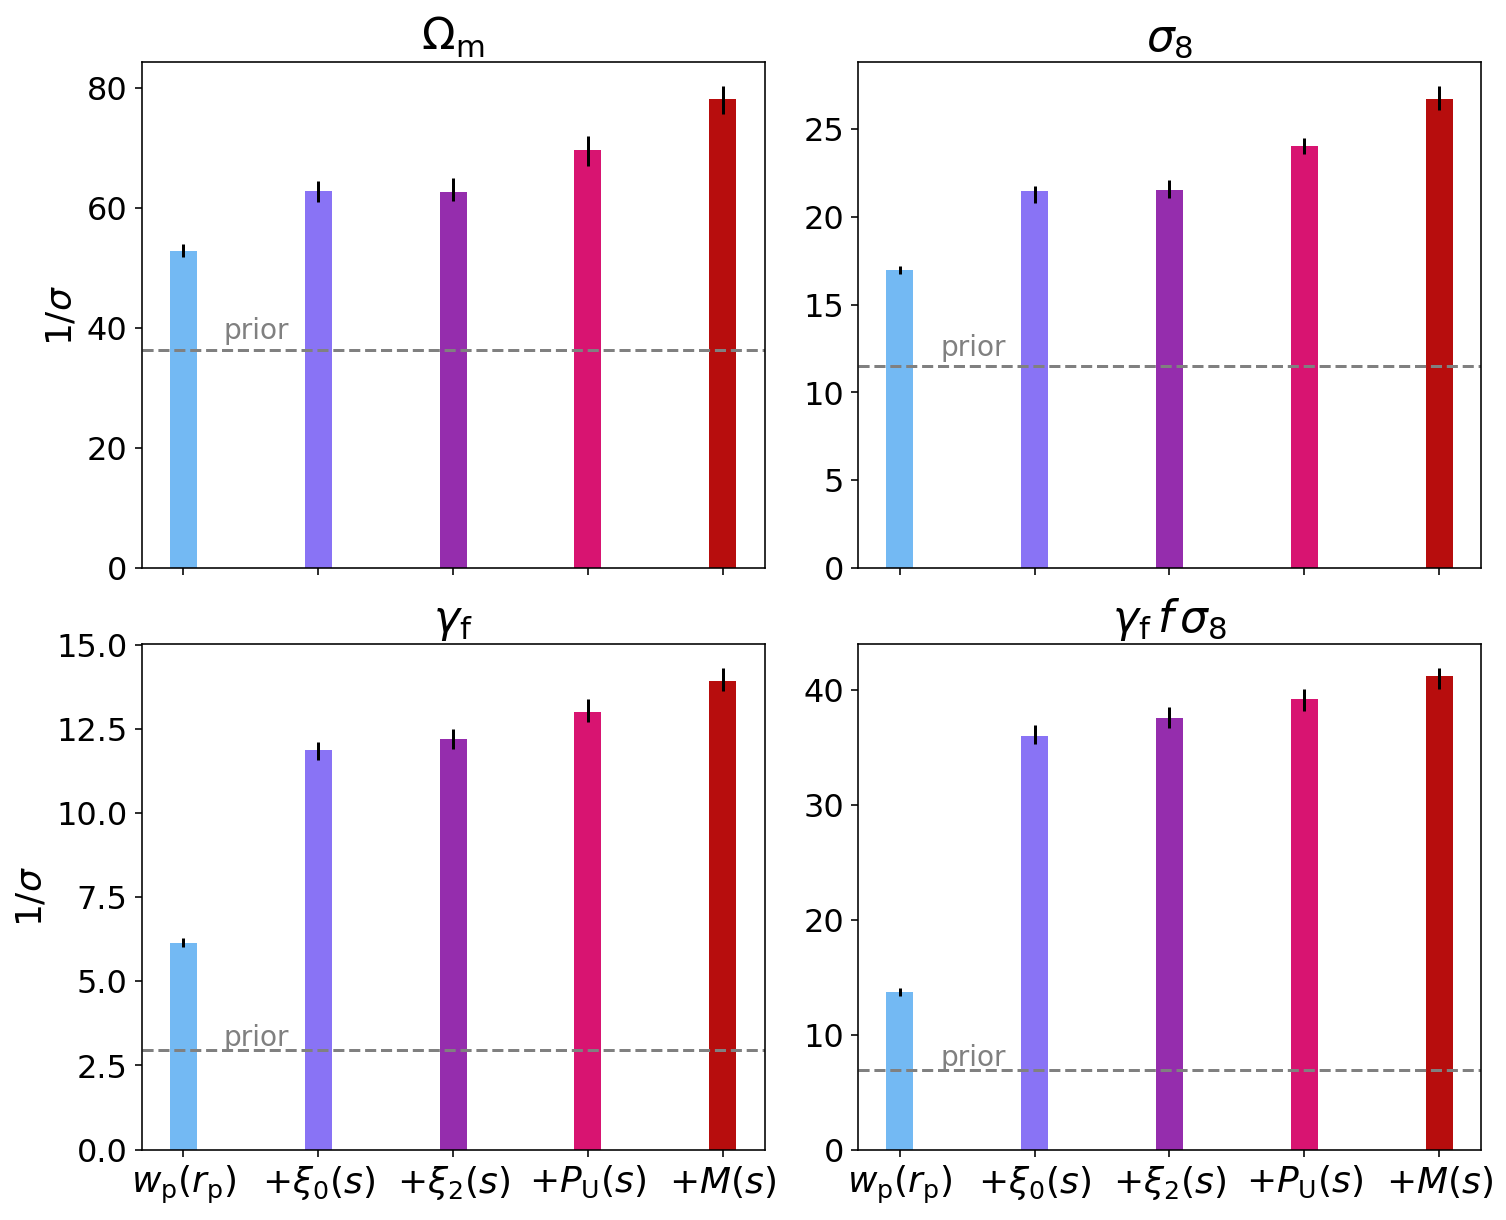

In [18]:
plotter.plot_uncertainty_figure(results_dict_addin_full, prior_dict, params_keydeliverable, stat_strs_addin_full, 
                                id_pairs, labels_addin, colors_addin)
plt.savefig(f'{plot_dir}/recovery_addin.pdf', bbox_inches='tight')

In [49]:
utils.print_uncertainty_results_abstract(results_dict_addin_full, params_keydeliverable, id_pairs, prior_dict)

Omega_m
Prior: 0.0273
wp: 0.0189
wp_xi_xi2: 0.0160
wp_xi_xi2_upf_mcf: 0.0128
Increased precision from standard to beyond by: 19.9%

sigma_8
Prior: 0.0858
wp: 0.0589
wp_xi_xi2: 0.0464
wp_xi_xi2_upf_mcf: 0.0374
Increased precision from standard to beyond by: 19.4%

f
Prior: 0.3350
wp: 0.1625
wp_xi_xi2: 0.0818
wp_xi_xi2_upf_mcf: 0.0718
Increased precision from standard to beyond by: 12.2%

fsigma8
Prior: 0.1420
wp: 0.0731
wp_xi_xi2: 0.0266
wp_xi_xi2_upf_mcf: 0.0243
Increased precision from standard to beyond by: 9.0%



### 70-model recovery test: cumulative distribution function

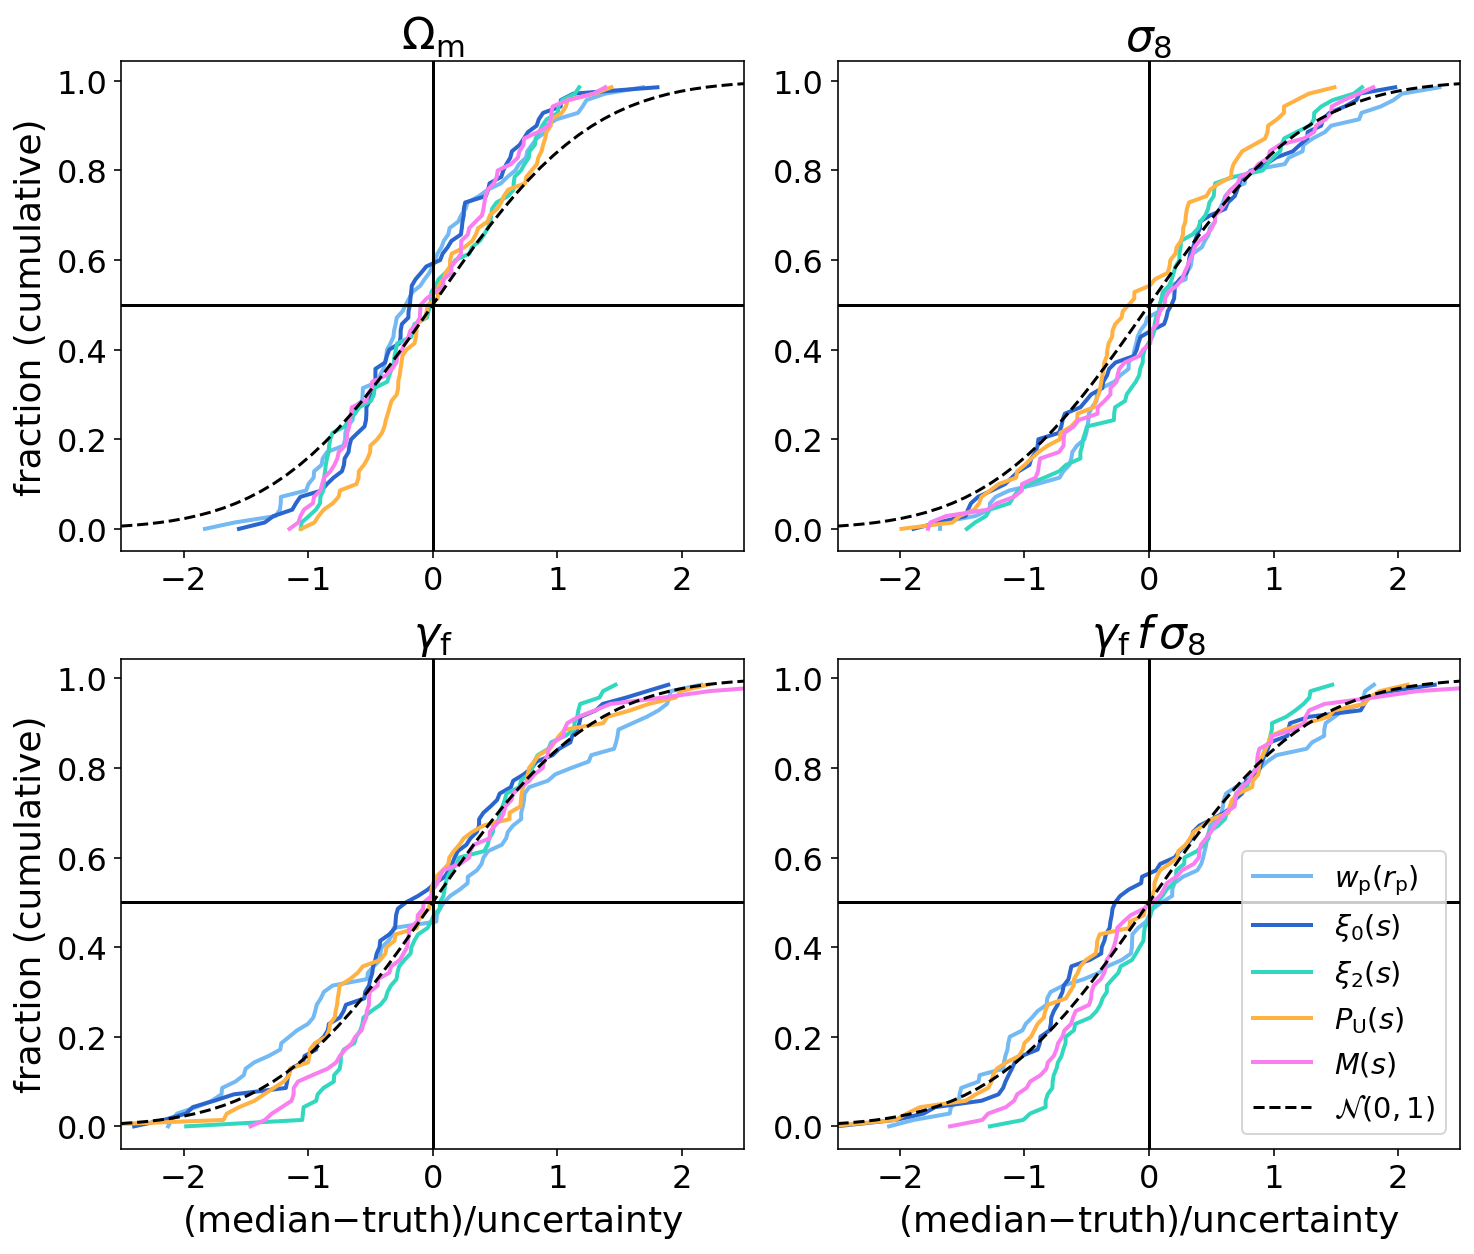

In [16]:
plotter.plot_cumulative_dist_figure(results_dict_single, params_keydeliverable, stat_strs_single, id_pairs, 
                                    labels_single, colors_single, divide_by_error=True)
plt.savefig(f'{plot_dir}/cdf_single.pdf', bbox_inches='tight')

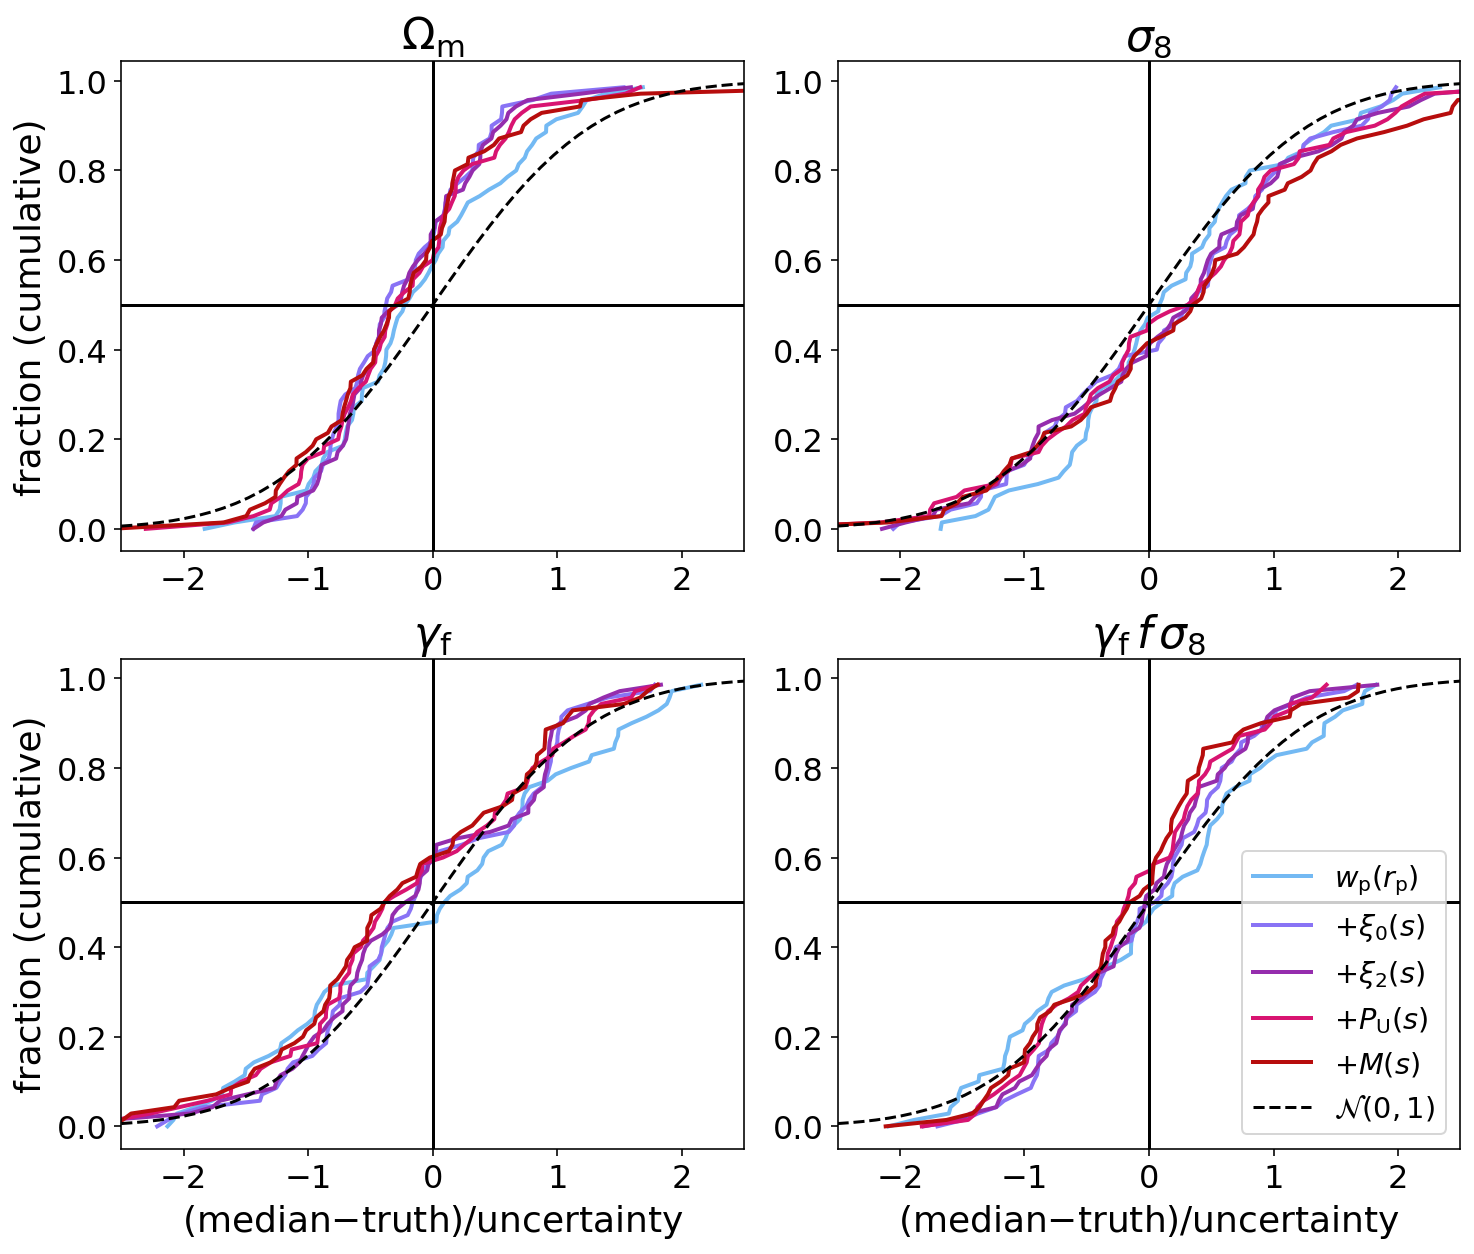

In [13]:
plotter.plot_cumulative_dist_figure(results_dict_addin_full, params_keydeliverable, stat_strs_addin_full, id_pairs, 
                                    labels_addin, colors_addin, divide_by_error=True)
plt.savefig(f'{plot_dir}/cdf_addin.pdf', bbox_inches='tight')

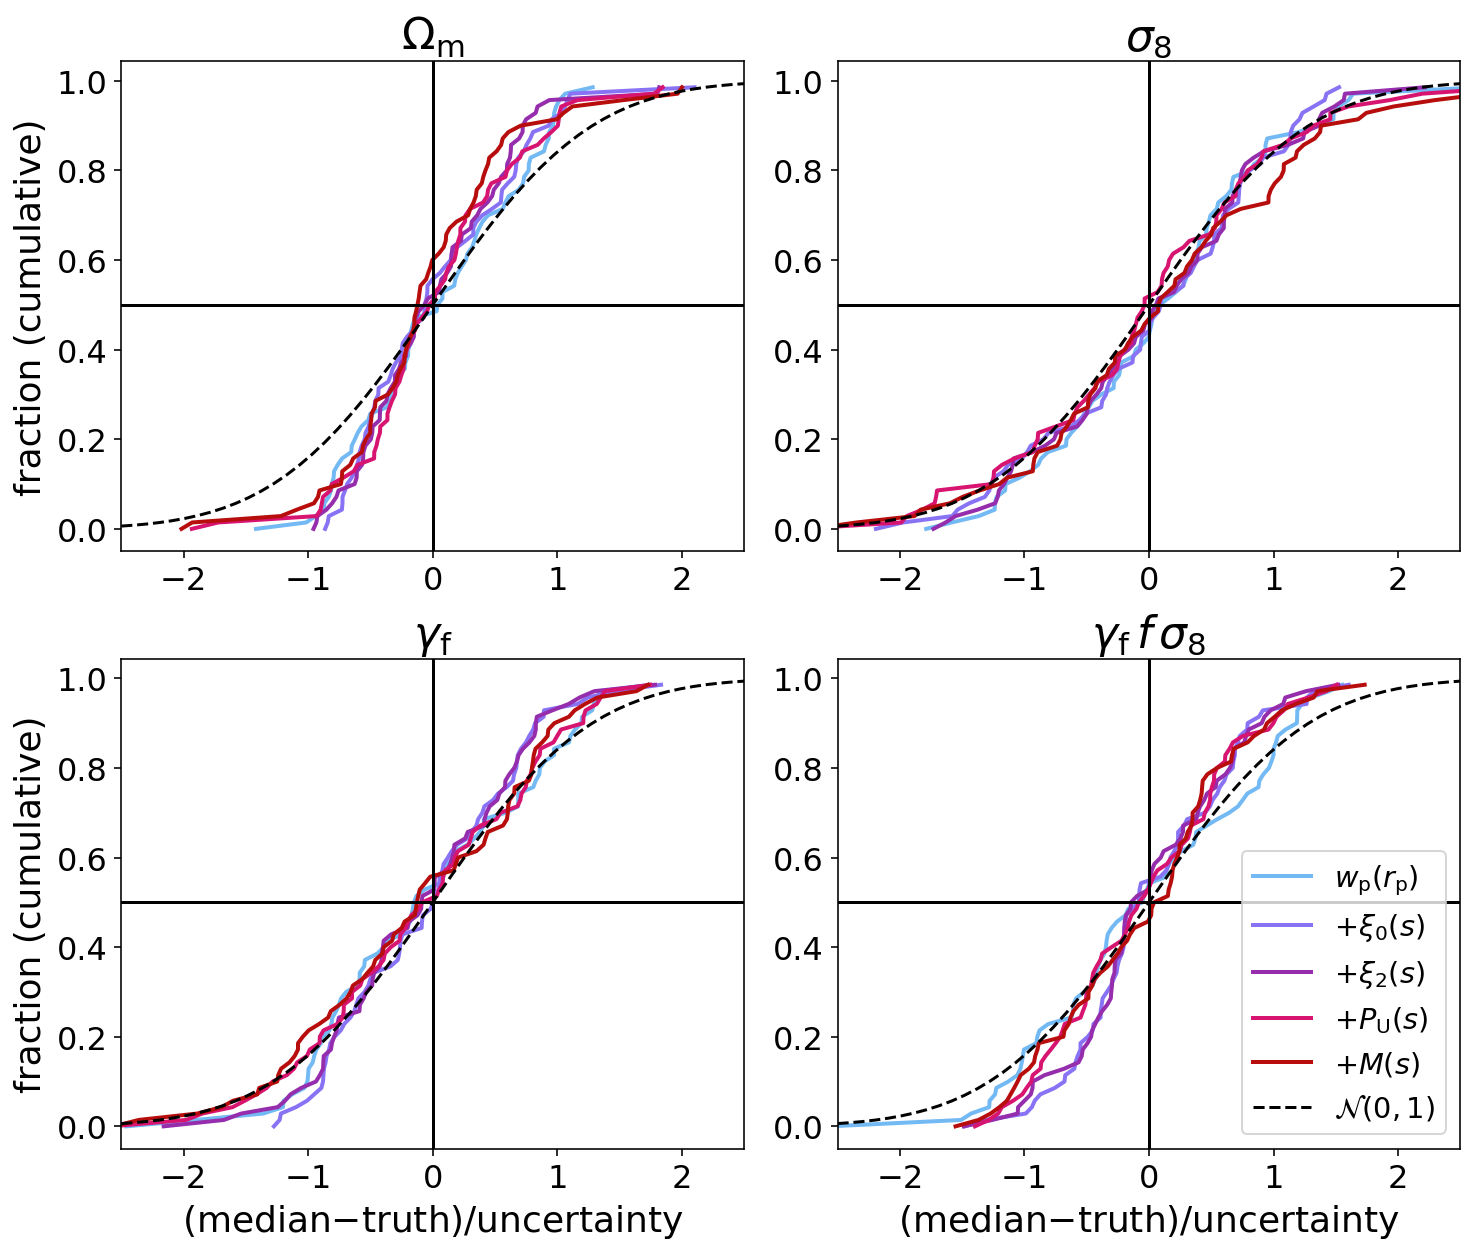

In [17]:
plotter.plot_cumulative_dist_figure(results_dict_wpximaxscale6, params_keydeliverable, stat_strs_addin_full, id_pairs, 
                                    labels_addin, colors_addin, divide_by_error=True)
plt.savefig(f'{plot_dir}/cdf_addin_wpximaxscale6.pdf', bbox_inches='tight')

In [ ]:
# plotter.plot_cumulative_dist_figure(results_dict_wpmaxscale6, params_keydeliverable, stat_strs_addin_full, id_pairs, 
#                                     labels_addin, colors_addin, divide_by_error=True)
# plt.savefig(f'{plot_dir}/cdf_addin_wpmaxscale6.pdf', bbox_inches='tight')

### Scales analysis

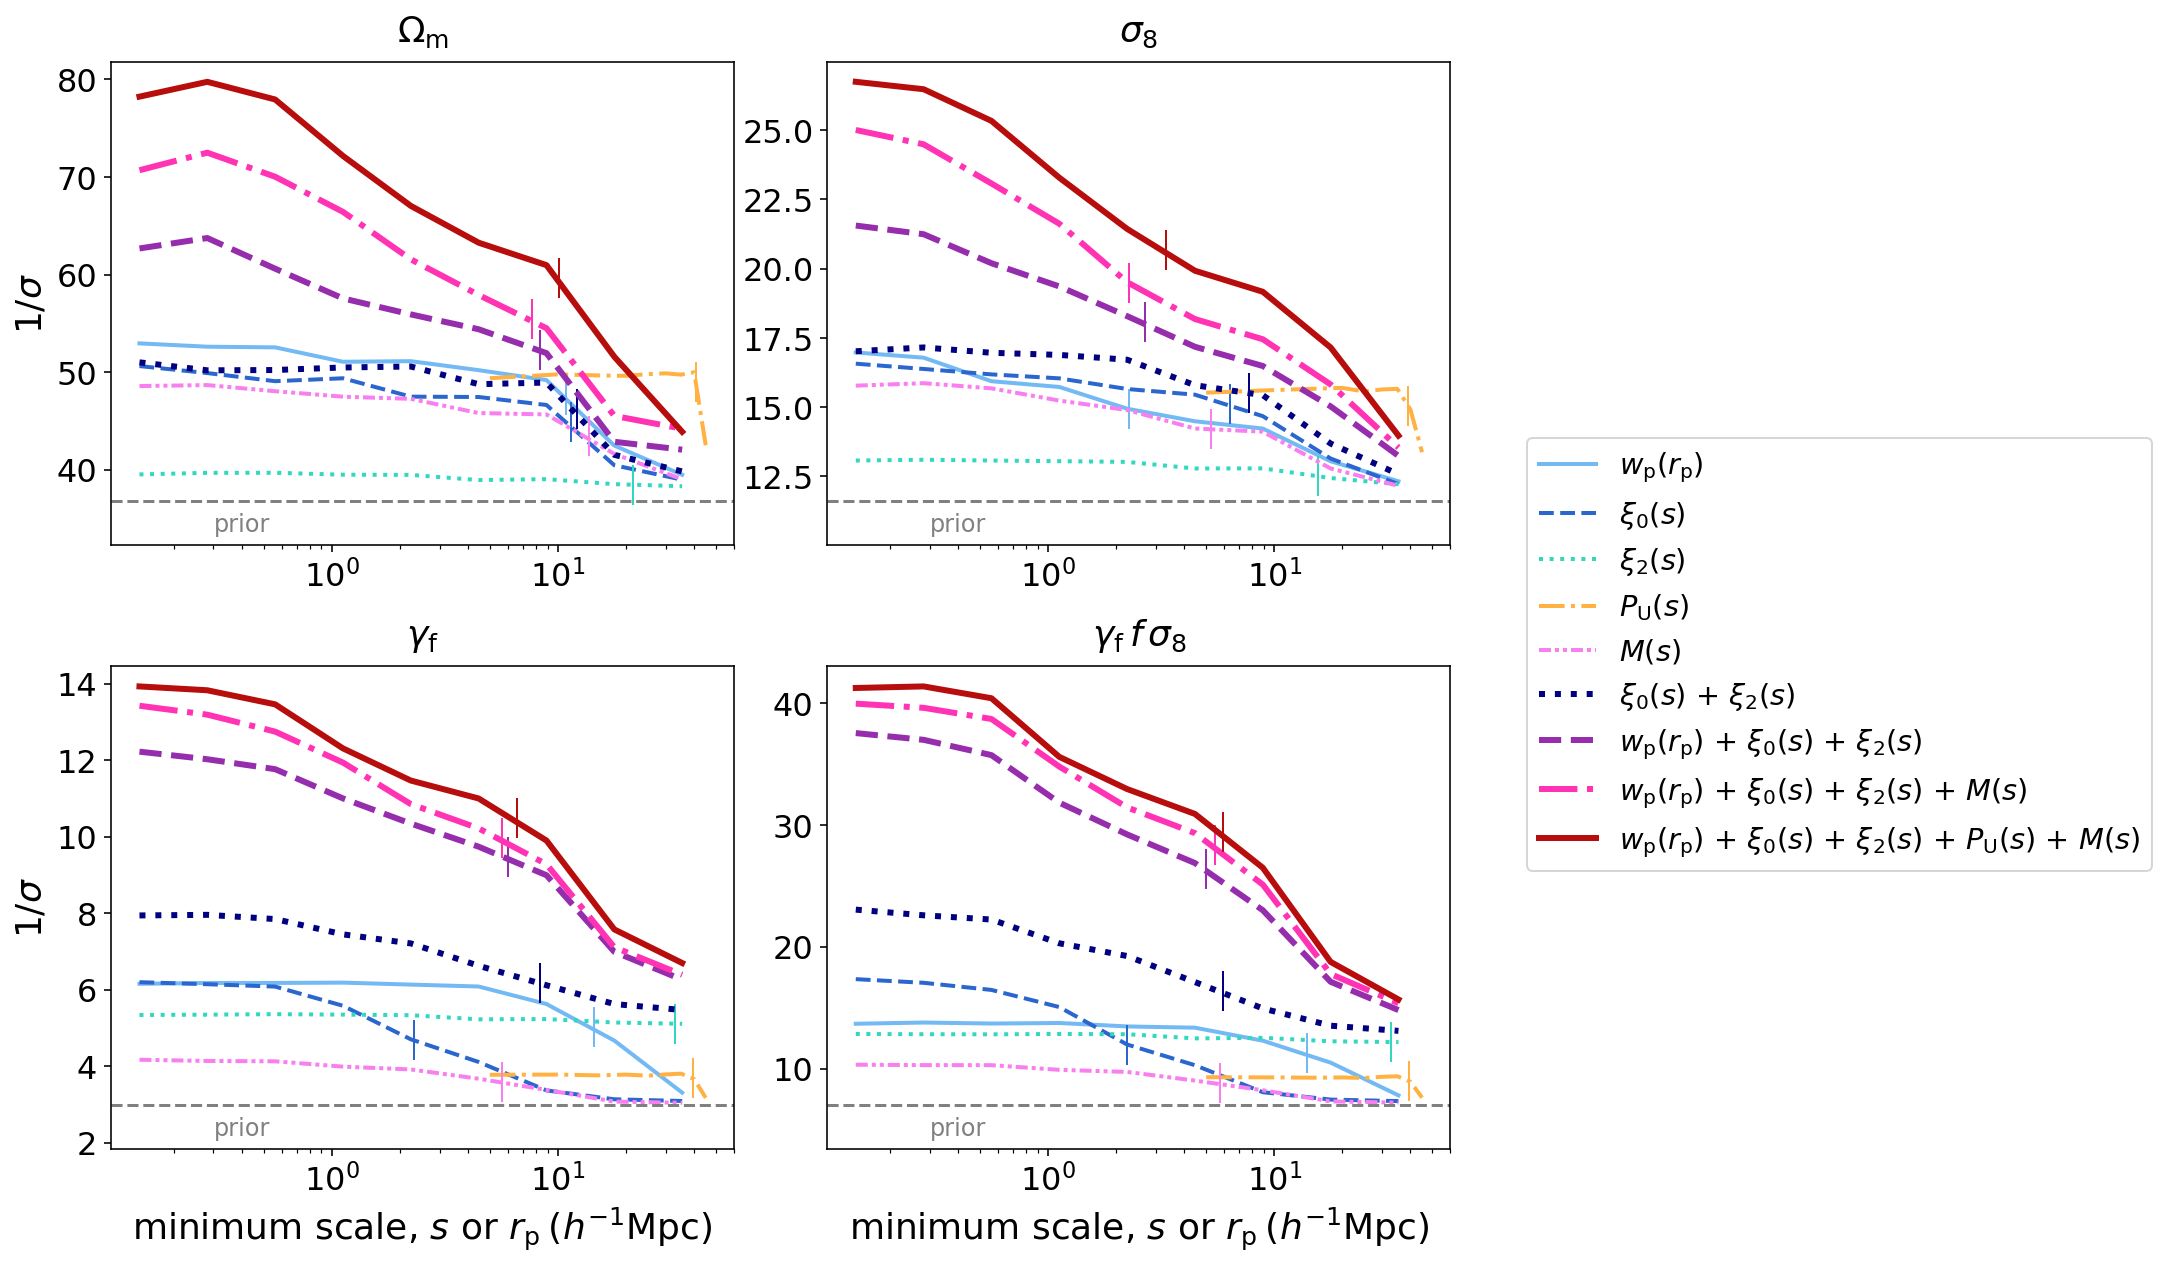

In [22]:
%matplotlib inline
lws = np.array([2,2,2,2,2,3,3,3,3])
long_dash = (0, (5, 10))
dash_dot_dot = (0, (3,1,1,1,1,1))
lss = np.array(['-', '--', ':', '-.', dash_dot_dot, ':', '--', '-.', '-'])
min_scales = np.arange(0,9)
plotter.plot_scale_dependence_figure(min_scales, results_dict_minscales, prior_dict, 
                             params_keydeliverable, stat_strs_scale, id_pairs, labels_scale, colors_scale,
                             lss=lss, lws=lws, xlabel=r'minimum scale, $s$ or $r_\mathrm{p} \: (h^{-1}\mathrm{Mpc})$',
                             comparison_dicts=results_dict_maxscales, 
                             show_top_axis=False)
plt.savefig(f'{plot_dir}/scale_dependence.pdf', bbox_inches='tight')

## plots for postdoc proposal

In [ ]:
%matplotlib inline
lws = np.array([3,3,3])
long_dash = (0, (5, 10))
lss = np.array([long_dash, '-.', '-'])
min_scales = np.arange(0,9)

stat_strs = ['wp_xi_xi2', 'wp_xi_xi2_mcf', 'wp_xi_xi2_upf_mcf']

labels = [make_label(stat_strs[0]), '+'+make_label('mcf'), '+'+make_label('upf')]
colors = colors_addin[2:5]
colors[1] = '#ff33b4'

ylabel = r"1/$\sigma$, inverse uncertainty"
plotter.plot_scale_dependence_figure(min_scales, results_dict_minscales, prior_dict, 
                             ['sigma_8', 'fsigma8'], stat_strs, id_pairs, labels, colors,
                             nrows=1, ncols=2, lss=lss, lws=lws, 
                             xlabel=r'minimum scale, $s \, / \, r_\mathrm{p} \: (h^{-1}\mathrm{Mpc})$',
                             ylabel=ylabel,
                             comparison_dicts=results_dict_maxscales, show_top_axis=False)
plt.savefig(f'{plot_dir}/scale_dependence_addin.pdf', bbox_inches='tight')

## Uchuu recovery

In [ ]:
%matplotlib inline
chaintags = [
             'wp_xi_xi2_uchuu_all_Msatmocks_covglamsmooth_boundsingle_uchuuchi2nclosest2000',
             'wp_xi_xi2_upf_mcf_uchuu_all_Msatmocks_covglamsmooth_boundsingle_uchuuchi2nclosest2000_inflateupferr2diag'
            ]
colors = [colors_addin[2], colors_addin[4]]
labels = [labels_addin_full[2], labels_addin_full[4]]
g = plotter.plot_contours(chaintags, colors=colors,
                          legend_labels=labels, legend_loc=(0.36, 0.8),
                          legend_fontsize=24,
                          params_toplot=cosmo_withf_param_names)
plt.savefig(f'{plot_dir}/uchuu_recovery.pdf', bbox_inches='tight')

# Appendix Figures

### Contour plots, single model recovery test: a) all cosmological parameters; b) all hod parameters; c) key cosmology + key HOD/AB parameters 

In [ ]:
chaintags = [
             'wp_c1h12_all',
             'wp_xi_c1h12_all',
             'wp_xi_xi2_c1h12_all',
             'wp_xi_xi2_upf_c1h12_all',
             'wp_xi_xi2_upf_mcf_c1h12_all',
            ]
g = plotter.plot_contours(chaintags, colors=colors_addin, 
                          legend_labels=labels_addin, legend_loc=(0.41, 0.83),
                          legend_fontsize=26,
                          params_toplot=cosmo_withf_param_names)
plt.savefig(f'{plot_dir}/contour_addin_allcosmo.pdf', bbox_inches='tight')

In [ ]:
chaintags = [
             'wp_c1h12_all',
             'wp_xi_c1h12_all',
             'wp_xi_xi2_c1h12_all',
             'wp_xi_xi2_upf_c1h12_all',
             'wp_xi_xi2_upf_mcf_c1h12_all',
            ]
g = plotter.plot_contours(chaintags, colors=colors_addin,
                          legend_labels=labels_addin, legend_loc=(0.33, 0.86),
                          legend_fontsize=28,
                          params_toplot=hod_nof_param_names)
plt.savefig(f'{plot_dir}/contour_addin_allhodab.pdf', bbox_inches='tight')

In [ ]:
chaintags = [
             'wp_c1h12_all',
             'wp_xi_c1h12_all',
             'wp_xi_xi2_c1h12_all',
             'wp_xi_xi2_upf_c1h12_all',
             'wp_xi_xi2_upf_mcf_c1h12_all',
            ]
g = plotter.plot_contours(chaintags, colors=colors_addin,
                          legend_labels=labels_addin, legend_loc=(0.56, 0.8),
                          legend_fontsize=24,
                          params_toplot=params_keymix)
plt.savefig(f'{plot_dir}/contour_addin_keymix.pdf', bbox_inches='tight')

### Contour plot, single model recovery test: for emulator performance & smoothed covariance matrices, key cosmological parameters

Two models to show well-behaved and poorly behaved posteriors

In [ ]:
labels_cov = [
             make_label(['wp', 'xi', 'xi2', 'upf', 'mcf']) + '\n(original covariance matrix)',
             make_label(['wp', 'xi', 'xi2', 'upf', 'mcf']) + '\n(smoothed covariance matrix)',
            ]

In [ ]:
chaintags = [
             'wp_xi_xi2_upf_mcf_c1h12_all_covemuperf',
             'wp_xi_xi2_upf_mcf_c1h12_all',
            ]
g = plotter.plot_contours(chaintags, colors=colors_cov, 
                          legend_labels=labels_cov, legend_loc='upper right',
                          legend_fontsize=24,
                          params_toplot=params_keymix, alpha=0.5)
plt.savefig(f'{plot_dir}/contour_cov_c1h12.pdf', bbox_inches='tight')

In [ ]:
chaintags = [
             'wp_xi_xi2_upf_mcf_c6h62_all_covemuperf',
             'wp_xi_xi2_upf_mcf_c6h62_all_minscale0',
            ]
g = plotter.plot_contours(chaintags, colors=colors_cov,
                          legend_labels=[],
                          params_toplot=params_keymix, alpha=0.5)
plt.savefig(f'{plot_dir}/contour_cov_c6h62.pdf')

### 70-model recovery test: Precision on HOD and AB parameters

In [ ]:
params_toplot = ['M_sat'] + ab_param_names
plotter.plot_uncertainty_figure(results_dict_addin_full, prior_dict, params_toplot, stat_strs_addin_full, 
                                id_pairs, labels_addin, colors_addin)
plt.savefig(f'{plot_dir}/recovery_hodab.pdf', bbox_inches='tight')

## Computing CMASS volume

In [ ]:
from astropy.cosmology import Planck15
import astropy.units as u

Compute volume of highest-redshift bin used in Aemulus V: 

In [ ]:
z_min, z_max = 0.48, 0.62
# From docs: This is the volume of the universe encompassed by redshifts less than z. 
# For the case of Ω𝑘=0 it is a sphere of radius comoving_distance but it is less intuitive if Ω𝑘 is not.
v_inner = Planck15.comoving_volume(z_min)
v_outer = Planck15.comoving_volume(z_max)
v_shell = v_outer - v_inner
v_shell = v_shell.to(u.Gpc**3)
v_shell_perh = v_shell * Planck15.h**3
print(f"Volume in shell between {z_min} < z < {z_max}: {v_shell:.3f} = {v_shell_perh.value:.3f} (Gpc/h)^3")

CMASS encompasses a fraction of the sky:

In [ ]:
area_allsky = 41252.96125 #deg^2
# cmass areas from this paper: https://academic.oup.com/mnras/article/460/4/4210/2609174
area_cmass_ngc, area_cmass_sgc = 6851, 2525
area_cmass = area_cmass_ngc + area_cmass_sgc
frac_sky_cmass = area_cmass/area_allsky
print(f"CMASS cover is {area_cmass} deg^2 which is {frac_sky_cmass:.3f} of the sky")

Full CMASS volume:

In [ ]:
z_min, z_max = 0.43, 0.7 # https://academic.oup.com/mnras/article/460/4/4210/2609174
v_inner = Planck15.comoving_volume(z_min)
v_outer = Planck15.comoving_volume(z_max)
v_shell = v_outer - v_inner
v_shell = v_shell.to(u.Gpc**3)
v_shell_perh = v_shell * Planck15.h**3

v_cmass = frac_sky_cmass * v_shell
v_cmass_perh = v_cmass * Planck15.h**3
print(f"Volume in shell between {z_min} < z < {z_max}: {v_shell:.3f} = {v_shell_perh.value:.3f} (Gpc/h)^3")

v_cmass = frac_sky_cmass * v_shell
v_cmass_perh = v_cmass * Planck15.h**3
print(f"CMASS cover is {area_cmass} deg^2 which is {frac_sky_cmass:.3f} of the sky")
print(f"CMASS volume in this shell is then {v_cmass:.3f} = {v_cmass_perh.value:.3f} (Gpc/h)^3")

For Aemulus V, used CMASS+LOWZ sky area of 8447:

In [ ]:
from astropy.cosmology import Planck15
import astropy.units as u

area_cmasslowz = 8447 #deg^2
area_allsky = 41252.96125 #deg^2
frac_sky_cmasslowz = area_cmasslowz / area_allsky

z_min, z_max = 0.48, 0.62 # Aemulus V
v_inner = Planck15.comoving_volume(z_min)
v_outer = Planck15.comoving_volume(z_max)
v_shell = v_outer - v_inner
v_shell = v_shell.to(u.Gpc**3)
v_shell_perh = v_shell * Planck15.h**3

v_cmasslowz = frac_sky_cmasslowz * v_shell
v_cmasslowz_perh = v_cmasslowz * Planck15.h**3
print(f"Volume in shell between {z_min} < z < {z_max}: {v_shell:.3f} = {v_shell_perh.value:.3f} (Gpc/h)^3")

print(f"CMASS+LOWZ cover is {area_cmasslowz} deg^2 which is {frac_sky_cmasslowz:.3f} of the sky")
print(f"CMASS volume in this shell is then {v_cmasslowz:.3f} = {v_cmasslowz_perh.value:.3f} (Gpc/h)^3")